In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import  sklearn.svm as svm
import pickle

# 1. Load Dataset 

In [2]:
os.listdir('dataset')

['current_app.csv', 'previous_app.csv']

In [3]:
org_dataset = pd.read_csv('dataset/current_app.csv', na_values= ["N/a", "na", "XNA", np.nan])
org_dataset.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
org_dataset.shape

(307511, 122)

Notice: the data set has about 307k rows and 122 features (regressors)

# 2. Cleaning Dataset

## 2.1 visulalize and analyze Nan Values in dataset

In [5]:
to_clean_dataset = org_dataset.copy()
to_clean_dataset.isnull().any().any()

True

<AxesSubplot:>

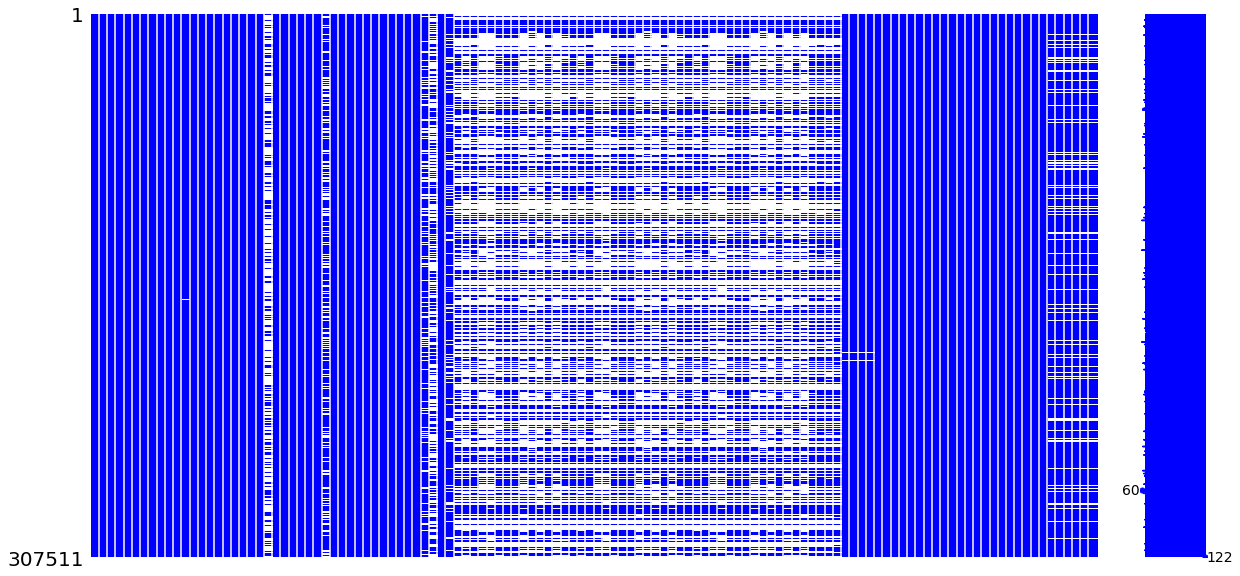

In [6]:
msno.matrix(to_clean_dataset,figsize=(20,10),color=(0, 0 ,1))

Notice: the dataset has many rows with a lot of Nan values 
recommended 1: to drop columns with nan values of percentage > 50% 

In [7]:
to_clean_dataset.dropna(thresh= to_clean_dataset.shape[0]* 0.5, axis = 1, inplace=True )
to_clean_dataset.shape

(307511, 81)

Notice: the number of columns decreased from 122 to 81 <br>
when dropped columns with nan values of percentage > 50% <br> 
recommended 2: fill columns with Nan values < 13% with mean or mode depending on column type 

In [8]:
dirty_cols =to_clean_dataset.columns[to_clean_dataset.isnull().sum() >0.13 * to_clean_dataset.shape[0]]
dirty_cols

Index(['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [9]:
to_clean_dataset[dirty_cols].head()

,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Laborers,Business Entity Type 3,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,0.0,0.0,0.0,0.0,0.0,1.0
1,Core staff,School,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,0.0,0.0,0.0,0.0,0.0,0.0
2,Laborers,Government,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,Laborers,Business Entity Type 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Core staff,Religion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


Notice: We will replace with mode values for categorical columns and mean for continous columns<br> 
but for this we will first check if there are any outliers so that the mean values would be correct

In [10]:
to_clean_dataset.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


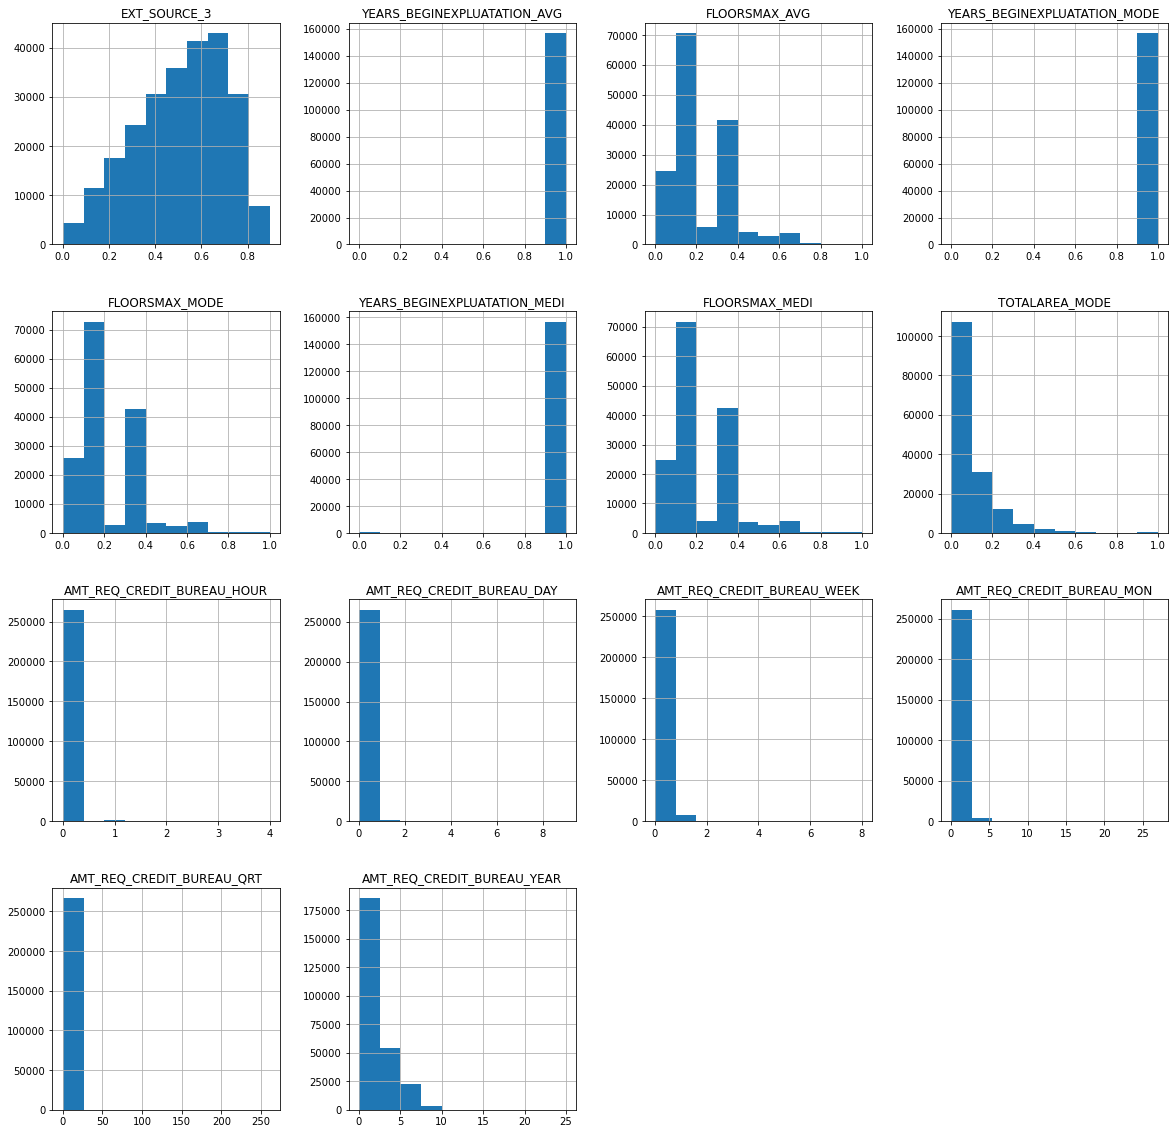

In [11]:
dirty_cols2 = dirty_cols.delete([0,1,10])
_ = to_clean_dataset[dirty_cols2].hist(figsize=(20,20) )

Notice: All columns seems to have valid values (ignoring Nan)<br> 
Now we can fill the columns with mean and mode

In [12]:
to_clean_dataset['OCCUPATION_TYPE'].fillna(value= to_clean_dataset['OCCUPATION_TYPE'].mode()[0] ,inplace = True )
to_clean_dataset['ORGANIZATION_TYPE'].fillna(value= to_clean_dataset['ORGANIZATION_TYPE'].mode()[0] ,inplace = True )
to_clean_dataset['EMERGENCYSTATE_MODE'].fillna(value= to_clean_dataset['EMERGENCYSTATE_MODE'].mode()[0] ,inplace = True )
to_clean_dataset['CODE_GENDER'].fillna(value= to_clean_dataset['CODE_GENDER'].mode()[0] ,inplace = True )

to_clean_dataset['EXT_SOURCE_3'].fillna(value= to_clean_dataset['EXT_SOURCE_3'].mean() ,inplace = True )
to_clean_dataset['YEARS_BEGINEXPLUATATION_AVG'].fillna(value= to_clean_dataset['YEARS_BEGINEXPLUATATION_AVG'].mean() ,inplace = True )
to_clean_dataset['FLOORSMAX_AVG'].fillna(value= to_clean_dataset['FLOORSMAX_AVG'].mean() ,inplace = True )
to_clean_dataset['YEARS_BEGINEXPLUATATION_MODE'].fillna(value= to_clean_dataset['YEARS_BEGINEXPLUATATION_MODE'].mean() ,inplace = True )
to_clean_dataset['FLOORSMAX_MODE'].fillna(value= to_clean_dataset['FLOORSMAX_MODE'].mean() ,inplace = True )
to_clean_dataset['YEARS_BEGINEXPLUATATION_MEDI'].fillna(value= to_clean_dataset['YEARS_BEGINEXPLUATATION_MEDI'].mean() ,inplace = True )
to_clean_dataset['TOTALAREA_MODE'].fillna(value= to_clean_dataset['TOTALAREA_MODE'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_HOUR'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_DAY'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_WEEK'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_MON'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_MON'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_QRT'].mean() ,inplace = True )
to_clean_dataset['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(value= to_clean_dataset['AMT_REQ_CREDIT_BUREAU_YEAR'].mean() ,inplace = True )

Notice: For columns with Nan values > 13% and <50% we will drop rows containing Nan values

In [13]:
to_clean_dataset.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [14]:
to_clean_dataset.dropna(inplace=True)
to_clean_dataset.isnull().any().any()

False

Notice: Now our dataset has no Nan values

In [15]:
# remove SK_ID_CURR Columns from dataset as it won't be useful for our problem 
to_clean_dataset = to_clean_dataset.drop(labels=['SK_ID_CURR'], axis = 1)

In [16]:
to_clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152854 entries, 0 to 307510
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   TARGET                        152854 non-null  int64  
 1   NAME_CONTRACT_TYPE            152854 non-null  object 
 2   CODE_GENDER                   152854 non-null  object 
 3   FLAG_OWN_CAR                  152854 non-null  object 
 4   FLAG_OWN_REALTY               152854 non-null  object 
 5   CNT_CHILDREN                  152854 non-null  int64  
 6   AMT_INCOME_TOTAL              152854 non-null  float64
 7   AMT_CREDIT                    152854 non-null  float64
 8   AMT_ANNUITY                   152854 non-null  float64
 9   AMT_GOODS_PRICE               152854 non-null  float64
 10  NAME_TYPE_SUITE               152854 non-null  object 
 11  NAME_INCOME_TYPE              152854 non-null  object 
 12  NAME_EDUCATION_TYPE           152854 non-nul

## 2.2 Check invalid values in dataset

In [17]:
to_clean_dataset.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,152854.000000,152854.000000,1.528540e+05,1.528540e+05,152854.000000,1.528540e+05,152854.000000,152854.000000,152854.00000,152854.000000,...,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000,152854.000000
mean,0.069943,0.389882,1.803566e+05,6.223780e+05,28110.483854,5.611715e+05,0.022279,-16125.508341,62299.15698,-5229.428487,...,0.008675,0.000667,0.000622,0.000347,0.006802,0.007682,0.035102,0.309023,0.267697,1.895175
std,0.255051,0.681378,3.172570e+05,4.195890e+05,15193.102685,3.863918e+05,0.015533,4370.645386,140072.63726,3617.461177,...,0.092735,0.025824,0.024922,0.018618,0.081236,0.112598,0.195219,0.979988,0.882385,1.757565
min,0.000000,0.000000,2.565000e+04,4.500000e+04,1993.500000,4.500000e+04,0.000290,-25229.000000,-17912.00000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.762775e+05,16965.000000,2.475000e+05,0.010032,-19758.000000,-2860.00000,-7920.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.575000e+05,5.235975e+05,25690.500000,4.545000e+05,0.019689,-15823.000000,-1241.00000,-4859.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.899974
75%,0.000000,1.000000,2.250000e+05,8.356050e+05,36000.000000,7.065000e+05,0.028663,-12510.000000,-299.00000,-2076.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267395,0.265474,3.000000
max,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7678.000000,365243.00000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,24.000000,261.000000,19.000000


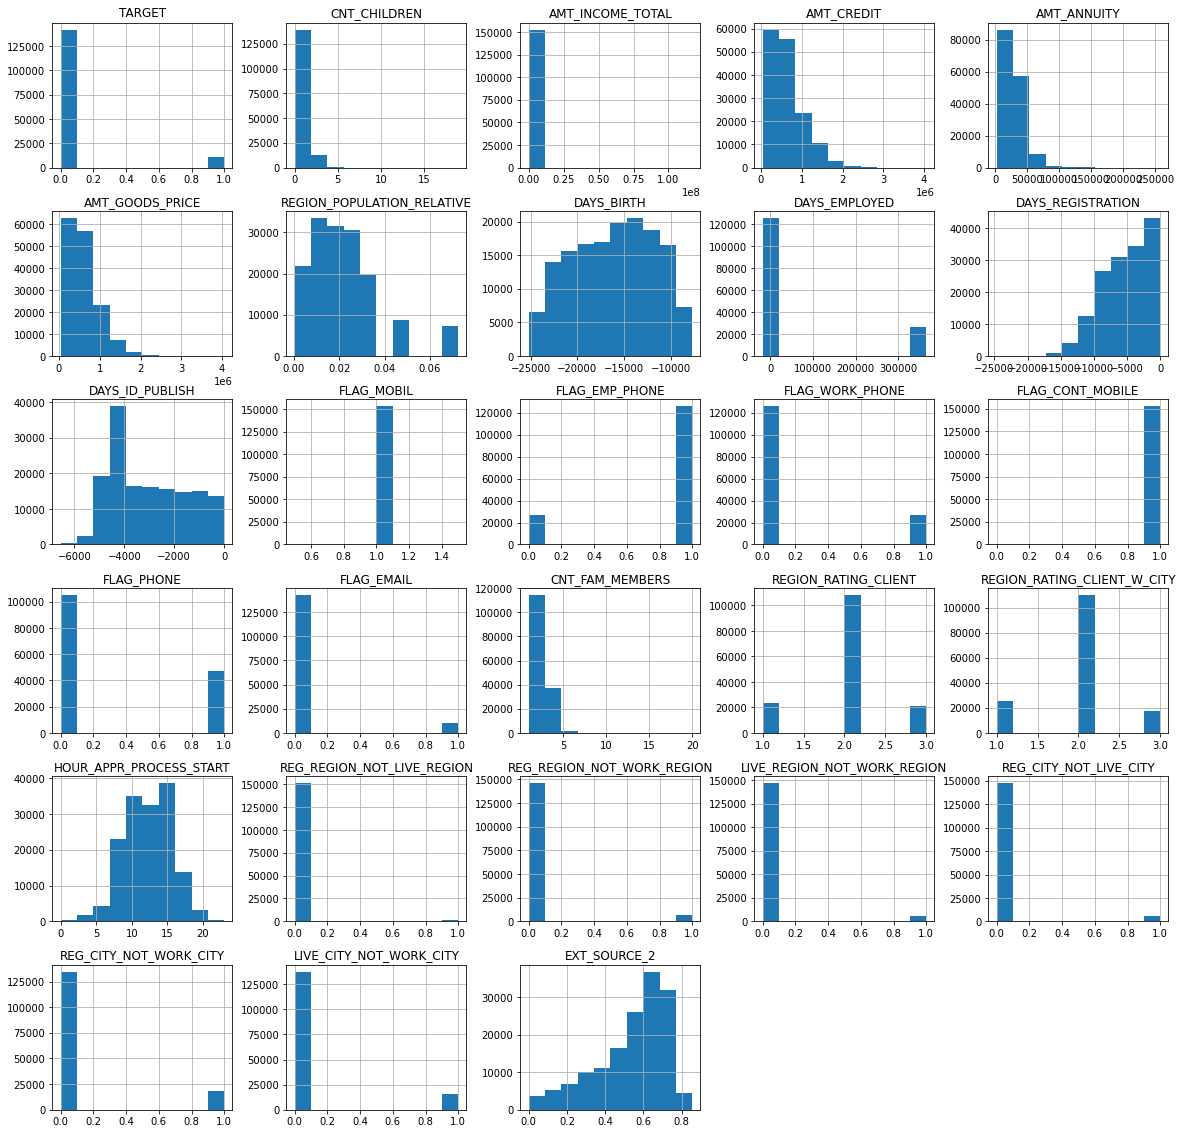

In [18]:
_ = to_clean_dataset[to_clean_dataset.columns[:len(to_clean_dataset.columns)//2]].hist(figsize=(20,20))

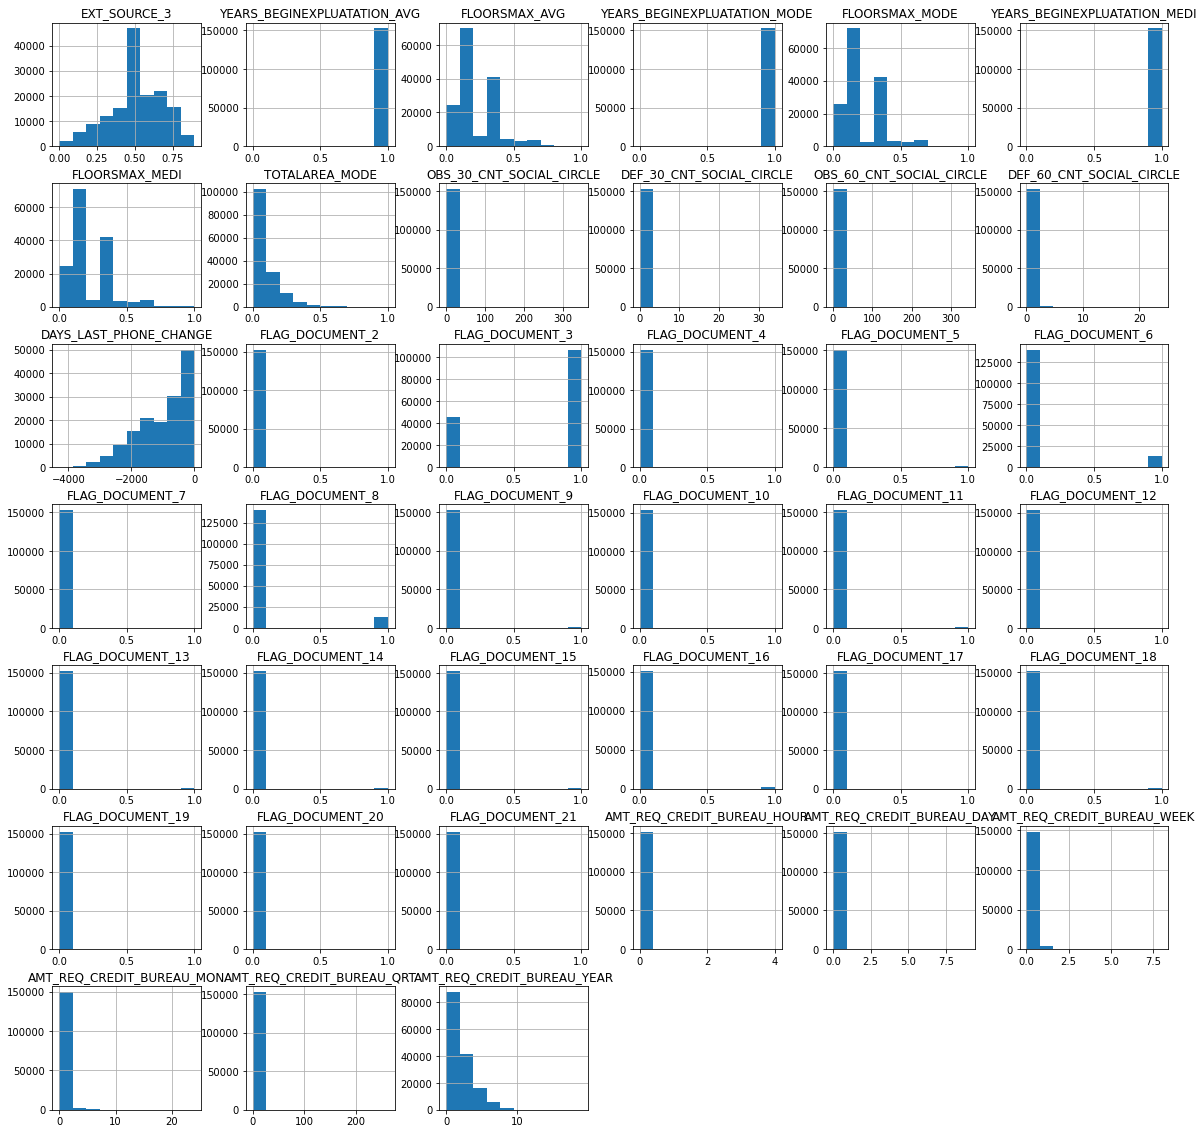

In [19]:
to_clean_dataset_ = to_clean_dataset[to_clean_dataset.columns[len(to_clean_dataset.columns)//2:]].hist(figsize=(20,20))

Notice: Some variables have negative values where they should be positive such as; <br> 
DAYS_BIRTH, DAYES_REGISTRATION, DAYES_ID_PUBLISH, DAYES_EMPLOYED, DAYES_LAST_PHONE_CHANGE <br> 
assuming the negative sign is added falsely we will convert values to positive

In [20]:
to_clean_dataset['DAYS_BIRTH'] = abs(to_clean_dataset['DAYS_BIRTH'] )
to_clean_dataset['DAYS_REGISTRATION'] = abs(to_clean_dataset['DAYS_REGISTRATION'] )
to_clean_dataset['DAYS_ID_PUBLISH'] = abs(to_clean_dataset['DAYS_ID_PUBLISH'] )
to_clean_dataset['DAYS_EMPLOYED'] = abs(to_clean_dataset['DAYS_EMPLOYED'] )
to_clean_dataset['DAYS_LAST_PHONE_CHANGE'] = abs(to_clean_dataset['DAYS_LAST_PHONE_CHANGE'] )

In [21]:
to_clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152854 entries, 0 to 307510
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   TARGET                        152854 non-null  int64  
 1   NAME_CONTRACT_TYPE            152854 non-null  object 
 2   CODE_GENDER                   152854 non-null  object 
 3   FLAG_OWN_CAR                  152854 non-null  object 
 4   FLAG_OWN_REALTY               152854 non-null  object 
 5   CNT_CHILDREN                  152854 non-null  int64  
 6   AMT_INCOME_TOTAL              152854 non-null  float64
 7   AMT_CREDIT                    152854 non-null  float64
 8   AMT_ANNUITY                   152854 non-null  float64
 9   AMT_GOODS_PRICE               152854 non-null  float64
 10  NAME_TYPE_SUITE               152854 non-null  object 
 11  NAME_INCOME_TYPE              152854 non-null  object 
 12  NAME_EDUCATION_TYPE           152854 non-nul

In [22]:
binary_features = [col for col in to_clean_dataset.columns if to_clean_dataset[col].unique().size <= 2]
binary_features

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EMERGENCYSTATE_MODE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [23]:
clean_dataset = to_clean_dataset.copy()

Notice: Considering the very large amount of features<br>  
We will apply bivariate analysis first to remove redundant features<br> 
then We will analyize the usefull features

# 3. Bivariate Analysis
## 3.1 Continuous Vs Continuous

In [24]:
clean_dataset.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [25]:
cont_cols = clean_dataset.columns[(clean_dataset.dtypes == 'int64')|(clean_dataset.dtypes == 'float64')]
cont_cols = [col for col in cont_cols if col not in binary_features]

In [26]:
def get_correlated(cor, thr):
    corr_idx = []
    for i in range(cor.shape[0]): 
        for j in range(i, cor.shape[1]): 
            if i != j and abs(cor[i,j]) >= thr:
                corr_idx.append((i,j))
    
    return corr_idx


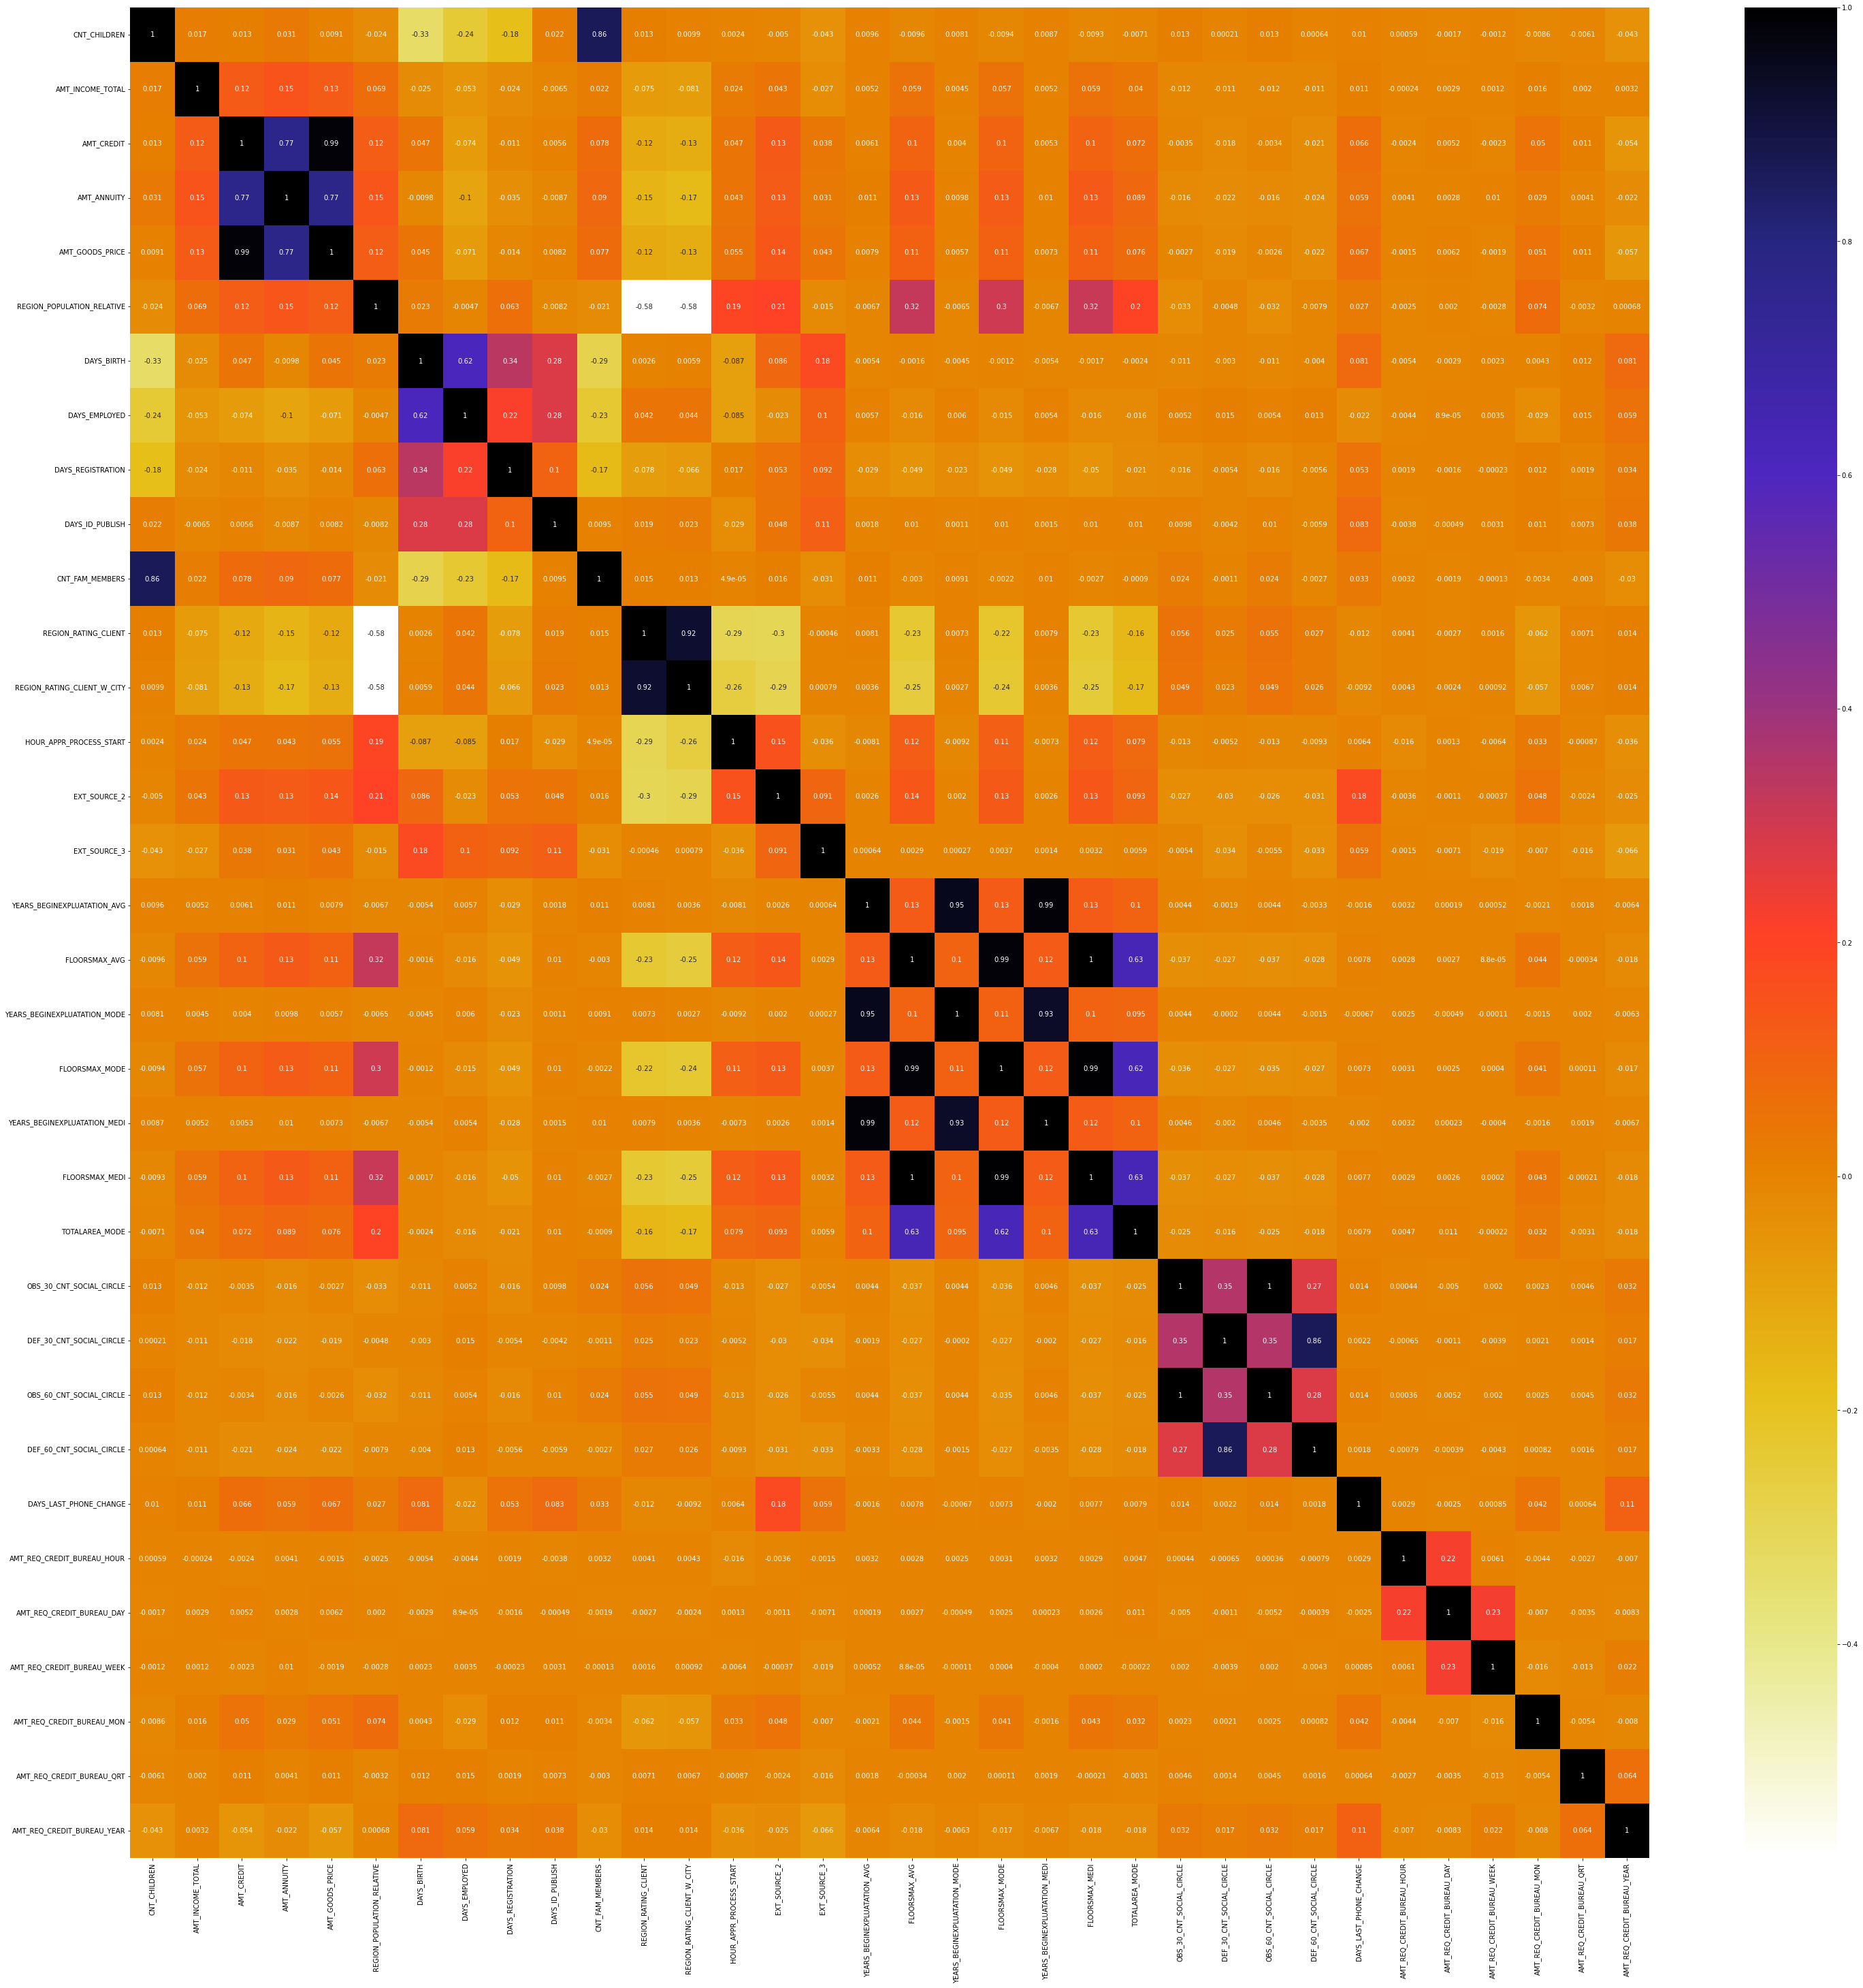

In [27]:
cor = clean_dataset[cont_cols].corr()
plt.figure(figsize=(50,50))
_ = sns.heatmap(data = cor ,cmap=plt.cm.CMRmap_r, annot= True)

Notice: From the heat map above we can see that some features are correlated.<br> 
So, we will remove features to get independent features. our correlation threshold is 0.85

In [28]:
corr_idx = get_correlated(cor.to_numpy(), 0.85)
indicies =np.unique([idx for idx,_ in corr_idx])
for idx in indicies:
    clean_dataset.drop(cont_cols[idx], axis = 1, inplace=True)
clean_dataset.shape

(152854, 71)

Notice: the features decreased from 80 to 71 features 

## 3.2 Continous Vs Output (Categorical)

In [29]:
cont_cols = clean_dataset.columns[(clean_dataset.dtypes == 'int64')|(clean_dataset.dtypes == 'float64')]
cont_cols = [col for col in cont_cols if col not in binary_features]

cat_cols = clean_dataset.columns[(clean_dataset.dtypes != 'int64')&(clean_dataset.dtypes != 'float64')].values
cat_cols = np.append(cat_cols, binary_features)

In [30]:
def cont_cat_boxplot(cat_col, cont_col):
    plt.figure()
    sns.boxplot(data = clean_dataset, x= cat_col, y = cont_col, order=clean_dataset[cat_col].value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()
    plt.close()
def cont_vs_out(out, cont_col):
    plt.figure()
    sns.boxplot(data = clean_dataset, x= out, y = cont_col, order=out.value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()
    plt.close()

Notice: We will remove features that are not useful for prediction<br> 
From the box plot, if Y axis has same distribution for all categories of categorical<br> 
feature on X axis, then there is no relation between Y axis and X axis, hence, we will remove this feature
because it is a weak regressor. 


AMT_INCOME_TOTAL


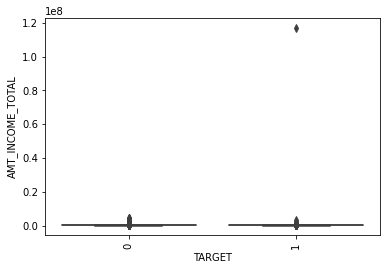

AMT_ANNUITY


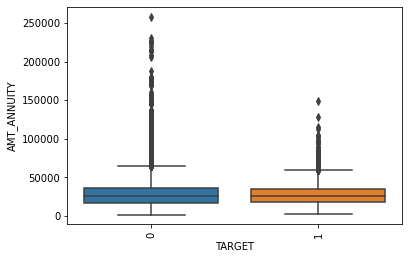

AMT_GOODS_PRICE


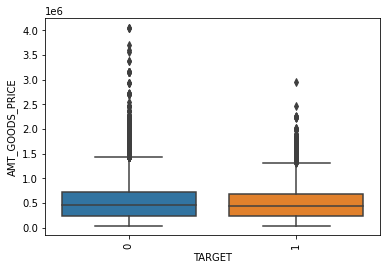

REGION_POPULATION_RELATIVE


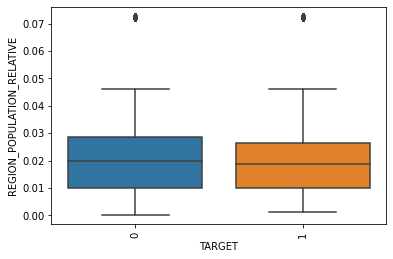

DAYS_BIRTH


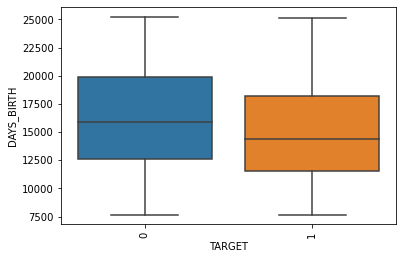

DAYS_EMPLOYED


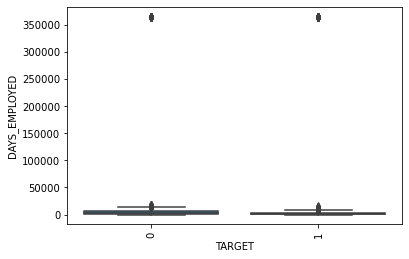

DAYS_REGISTRATION


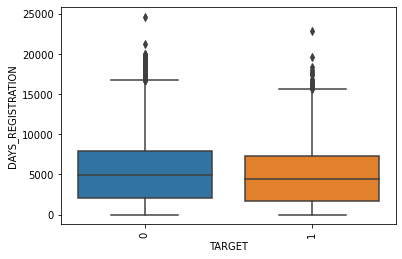

DAYS_ID_PUBLISH


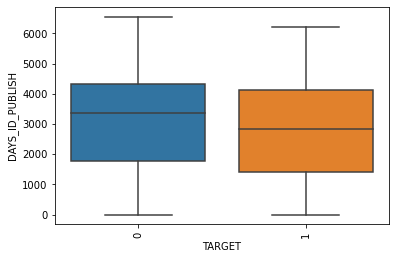

CNT_FAM_MEMBERS


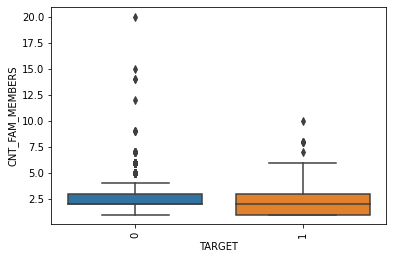

REGION_RATING_CLIENT_W_CITY


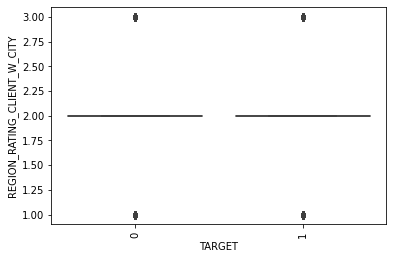

HOUR_APPR_PROCESS_START


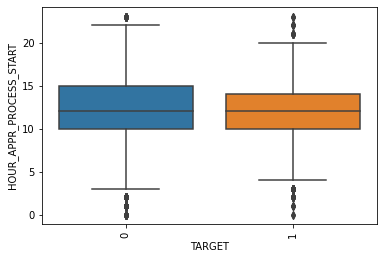

EXT_SOURCE_2


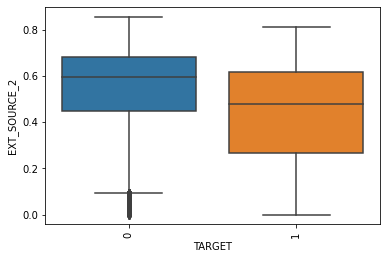

EXT_SOURCE_3


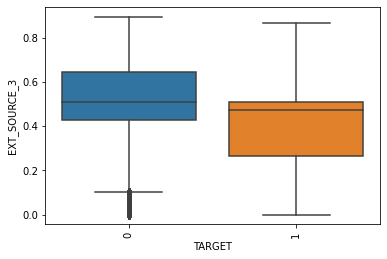

YEARS_BEGINEXPLUATATION_MEDI


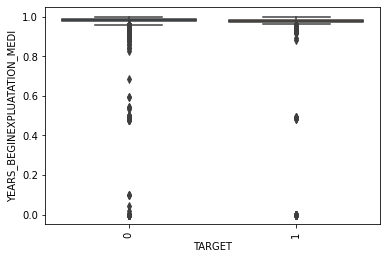

FLOORSMAX_MEDI


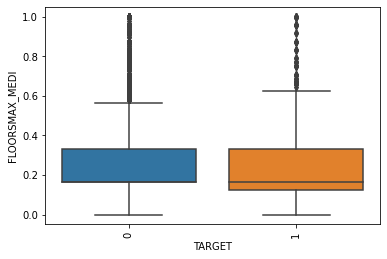

TOTALAREA_MODE


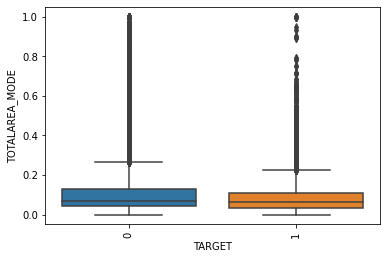

OBS_60_CNT_SOCIAL_CIRCLE


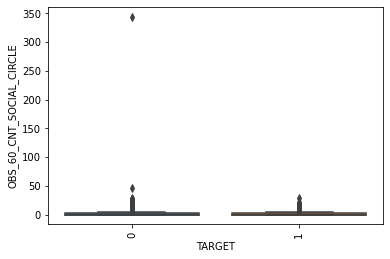

DEF_60_CNT_SOCIAL_CIRCLE


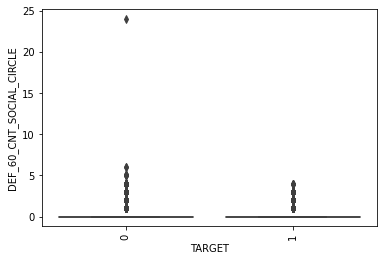

DAYS_LAST_PHONE_CHANGE


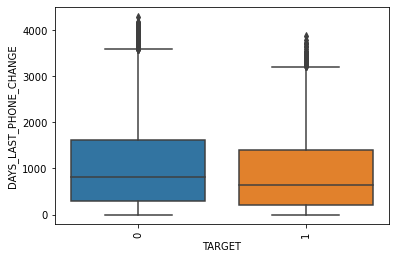

AMT_REQ_CREDIT_BUREAU_HOUR


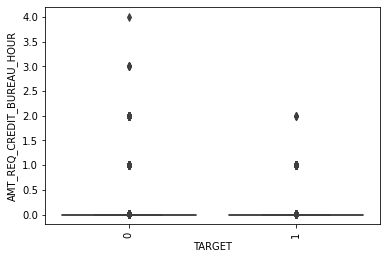

AMT_REQ_CREDIT_BUREAU_DAY


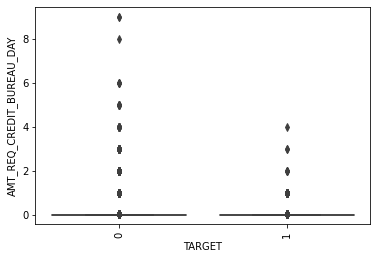

AMT_REQ_CREDIT_BUREAU_WEEK


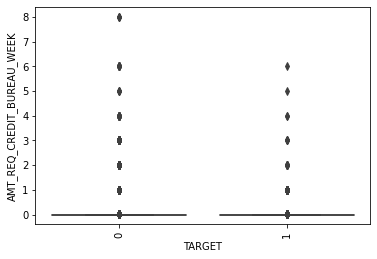

AMT_REQ_CREDIT_BUREAU_MON


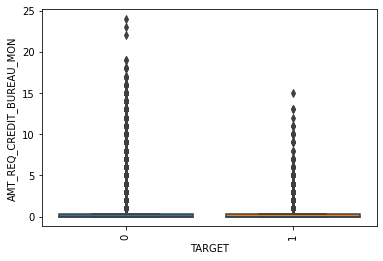

AMT_REQ_CREDIT_BUREAU_QRT


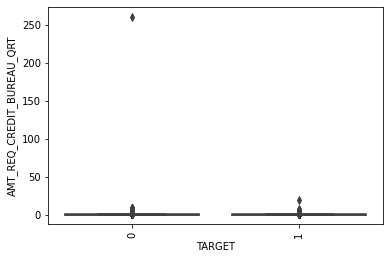

AMT_REQ_CREDIT_BUREAU_YEAR


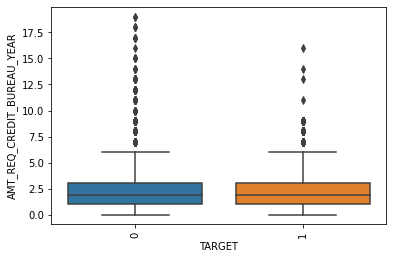

In [31]:
Y = clean_dataset['TARGET']
for j in range(len(cont_cols)):
    print(cont_cols[j])
    cont_vs_out(Y, cont_cols[j])

Notice: After drawing box plot of continuous features vs output TARGET<br> 
We notice that the distribution for many features is almost the same for both output values<br> 
Which indicates that the output doesn't depend on those features. From the above plot we decided to remove the following features as they won't be useful: ['REGION_POPULATION_RELATIVE', 'DAYS_BIRTH','DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH','REGION_RATING_CLIENT_W_CITY','HOUR_APPR_PROCESS_START'
                    'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','LIVE_CITY_NOT_WORK_CITY',
                    'YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_MEDI','TOTALAREA_MODE','DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR']

In [32]:
# added 'DAYS_BIRTH', 'DAYS_ID_PUBLISH' , 'HOUR_APPR_PROCESS_START', 'FLOORSMAX_MEDI'
useless_features = ['AMT_ANNUITY','AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE','DAYS_REGISTRATION',
                    'REGION_RATING_CLIENT_W_CITY',
                    'YEARS_BEGINEXPLUATATION_MEDI','TOTALAREA_MODE','DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR']
len(useless_features)

13

Notice: Columns; OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_QRT, AMT_INCOME_TOTAL, DAYS_EMPLOYED have outlier we will remove the ouliers and see distribution again

In [33]:
clean_dataset.drop((clean_dataset[clean_dataset.OBS_60_CNT_SOCIAL_CIRCLE > 40].index), axis = 0, inplace= True)
clean_dataset.drop((clean_dataset[clean_dataset.DEF_60_CNT_SOCIAL_CIRCLE > 20].index), axis = 0, inplace= True)
clean_dataset.drop((clean_dataset[clean_dataset.AMT_REQ_CREDIT_BUREAU_QRT > 200].index), axis = 0, inplace= True)
clean_dataset.drop((clean_dataset[clean_dataset.AMT_INCOME_TOTAL > 0.4e6].index), axis = 0, inplace= True)
clean_dataset.drop((clean_dataset[clean_dataset.DAYS_EMPLOYED > 300000].index), axis = 0, inplace= True)

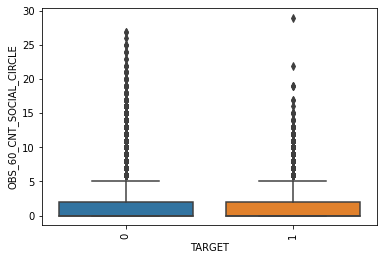

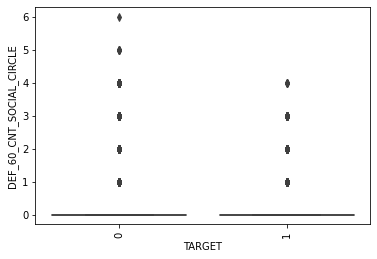

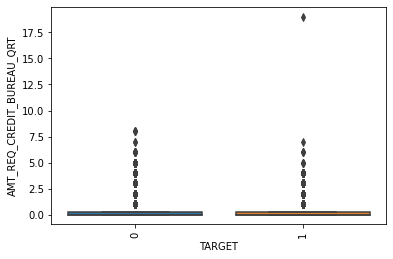

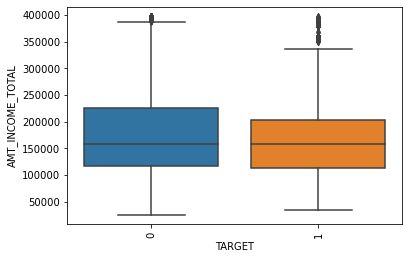

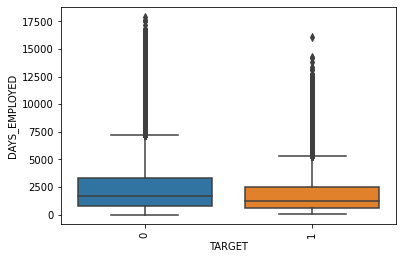

In [34]:
cont_vs_out(Y, clean_dataset.OBS_60_CNT_SOCIAL_CIRCLE)
cont_vs_out(Y, clean_dataset.DEF_60_CNT_SOCIAL_CIRCLE)
cont_vs_out(Y, clean_dataset.AMT_REQ_CREDIT_BUREAU_QRT)
cont_vs_out(Y, clean_dataset.AMT_INCOME_TOTAL)
cont_vs_out(Y, clean_dataset.DAYS_EMPLOYED)

Notice: They also are independent of output so we will remove them too except DAYS_EMPLOYES, AMT_INCOME_TOTAL there is sort of dependence

In [35]:
useless_features.extend(['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT'])

In [36]:
clean_dataset.drop(useless_features, axis = 1, inplace= True)

In [37]:
clean_dataset.shape

(121091, 55)

Notice Now we have 51 regressors

## 3.3 Binary Categorical Vs Output (binary categorical) 
### For this problem we will use pearson r method to calculate correlation between 
### binary categorical and output

In [38]:
#convert binary categorical to numerical values
clean_dataset['FLAG_OWN_REALTY'] = pd.get_dummies(clean_dataset['FLAG_OWN_REALTY'], drop_first=True, prefix = 'FLAG_OWN_REALTY')
clean_dataset['FLAG_OWN_CAR'] = pd.get_dummies(clean_dataset['FLAG_OWN_CAR'], drop_first=True, prefix = 'FLAG_OWN_CAR')
clean_dataset['CODE_GENDER'] = pd.get_dummies(clean_dataset['CODE_GENDER'], drop_first=True, prefix = 'CODE_GENDER')
clean_dataset['NAME_CONTRACT_TYPE'] = pd.get_dummies(clean_dataset['NAME_CONTRACT_TYPE'], drop_first=True, prefix = 'NAME_CONTRACT_TYPE')
clean_dataset['EMERGENCYSTATE_MODE'] = pd.get_dummies(clean_dataset['EMERGENCYSTATE_MODE'], drop_first=True, prefix = 'EMERGENCYSTATE_MODE')

In [39]:
for i in range(len(binary_features)):
    r = stats.pearsonr(clean_dataset[binary_features[i]], clean_dataset['TARGET'])
    print(f'corr of {binary_features[i]} vs TARGET = {r}')

corr of TARGET vs TARGET = (1.0, 0.0)
corr of NAME_CONTRACT_TYPE vs TARGET = (-0.03501720907595893, 3.5599247639335747e-34)
corr of CODE_GENDER vs TARGET = (0.050294539765174104, 1.1510510049474642e-68)
corr of FLAG_OWN_CAR vs TARGET = (-0.026556298975166724, 2.4051033660933638e-20)
corr of FLAG_OWN_REALTY vs TARGET = (-0.0031587545519778295, 0.27169000634770574)
corr of FLAG_MOBIL vs TARGET = (nan, nan)
corr of FLAG_EMP_PHONE vs TARGET = (0.0020118348687653124, 0.48388081883272754)
corr of FLAG_WORK_PHONE vs TARGET = (0.015808703832731884, 3.767432514058697e-08)
corr of FLAG_CONT_MOBILE vs TARGET = (-0.0024558807940875888, 0.3927764430075735)
corr of FLAG_PHONE vs TARGET = (-0.023450483717807016, 3.31250469138788e-16)
corr of FLAG_EMAIL vs TARGET = (-0.004339168996337141, 0.13105840783971506)
corr of REG_REGION_NOT_LIVE_REGION vs TARGET = (-0.0004998430411727571, 0.8619171295160761)
corr of REG_REGION_NOT_WORK_REGION vs TARGET = (-0.00030974032865740183, 0.9141680355327916)
corr of LI

/home/khalid/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Notice: All binary features except CODE_GENDER, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,FLAG_PHONE, 
REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3 doesn't have any correlation with output, so we will drop all of them

In [40]:
binary_to_keep = ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR','FLAG_PHONE', 
'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_3','TARGET']
features = [f for f in binary_features if f not in binary_to_keep]
clean_dataset.drop(features, axis = 1, inplace=True)
clean_dataset.shape

(121091, 25)

In [41]:
clean_dataset.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_MEDI,FLAG_DOCUMENT_3
0,1,0,1,0,202500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,...,1.0,WEDNESDAY,10,0,0,Business Entity Type 3,0.262949,0.139376,0.0833,1
1,0,0,0,0,270000.0,Family,State servant,Higher education,Married,House / apartment,...,2.0,MONDAY,11,0,0,School,0.622246,0.510853,0.2917,1
12,0,0,0,0,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,...,2.0,FRIDAY,10,0,0,Business Entity Type 2,0.715042,0.176653,0.1667,1
13,0,0,1,1,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,...,3.0,THURSDAY,13,0,0,Self-employed,0.566907,0.770087,0.3333,1
14,0,0,0,0,189000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,...,2.0,MONDAY,9,0,0,Transport: type 2,0.642656,0.510853,0.6667,1


In [42]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121091 entries, 0 to 307510
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      121091 non-null  int64  
 1   NAME_CONTRACT_TYPE          121091 non-null  uint8  
 2   CODE_GENDER                 121091 non-null  uint8  
 3   FLAG_OWN_CAR                121091 non-null  uint8  
 4   AMT_INCOME_TOTAL            121091 non-null  float64
 5   NAME_TYPE_SUITE             121091 non-null  object 
 6   NAME_INCOME_TYPE            121091 non-null  object 
 7   NAME_EDUCATION_TYPE         121091 non-null  object 
 8   NAME_FAMILY_STATUS          121091 non-null  object 
 9   NAME_HOUSING_TYPE           121091 non-null  object 
 10  DAYS_BIRTH                  121091 non-null  int64  
 11  DAYS_EMPLOYED               121091 non-null  int64  
 12  DAYS_ID_PUBLISH             121091 non-null  int64  
 13  FLAG_PHONE    

## 3.4 Multiple Categorical Vs Continuous


In [43]:
cat_cols = clean_dataset.columns[(clean_dataset.dtypes == 'object')]
cont_cols = clean_dataset.columns[(clean_dataset.dtypes == 'int64')|(clean_dataset.dtypes == 'float64')]
cont_cols = [col for col in cont_cols if col not in binary_features]

AMT_INCOME_TOTAL vs NAME_TYPE_SUITE


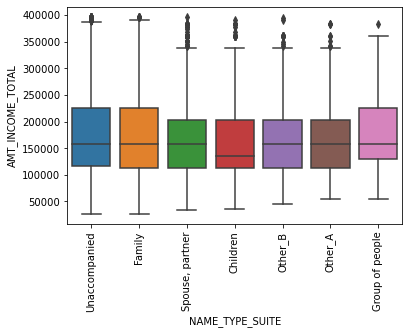

AMT_INCOME_TOTAL vs NAME_INCOME_TYPE


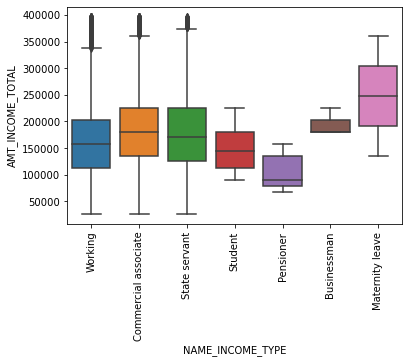

AMT_INCOME_TOTAL vs NAME_EDUCATION_TYPE


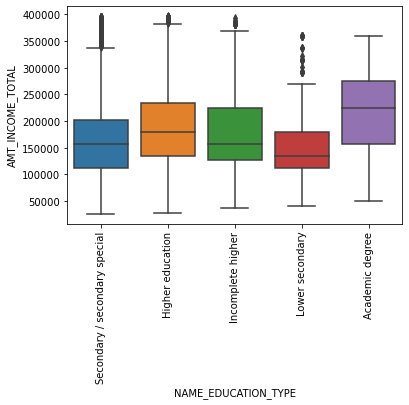

AMT_INCOME_TOTAL vs NAME_FAMILY_STATUS


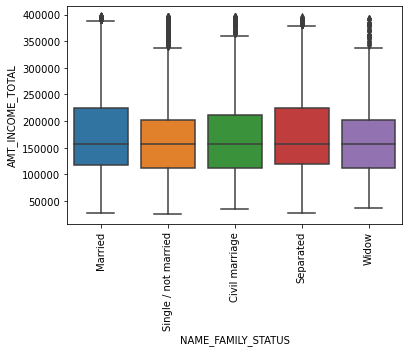

AMT_INCOME_TOTAL vs NAME_HOUSING_TYPE


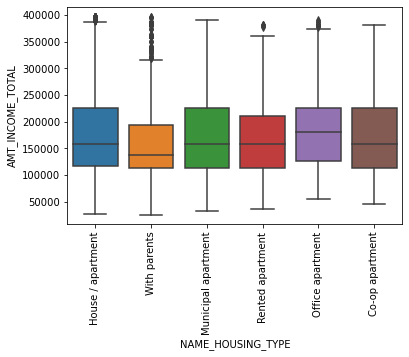

AMT_INCOME_TOTAL vs OCCUPATION_TYPE


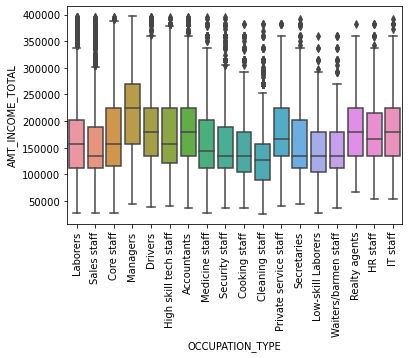

AMT_INCOME_TOTAL vs WEEKDAY_APPR_PROCESS_START


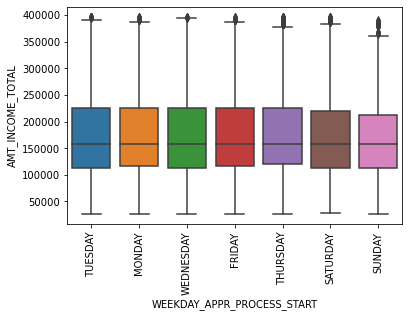

AMT_INCOME_TOTAL vs ORGANIZATION_TYPE


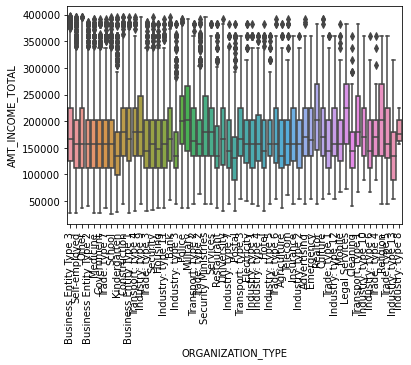

DAYS_BIRTH vs NAME_TYPE_SUITE


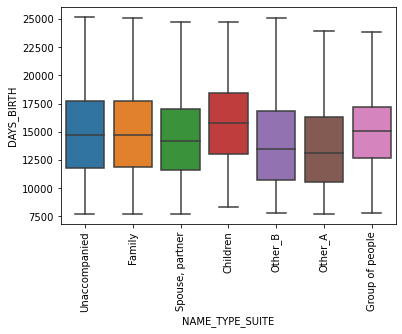

DAYS_BIRTH vs NAME_INCOME_TYPE


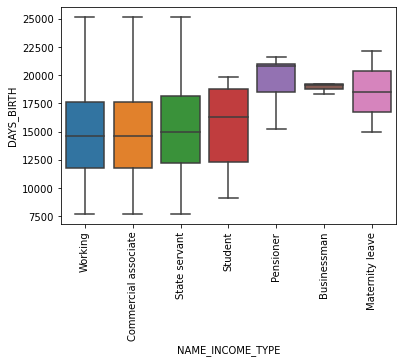

DAYS_BIRTH vs NAME_EDUCATION_TYPE


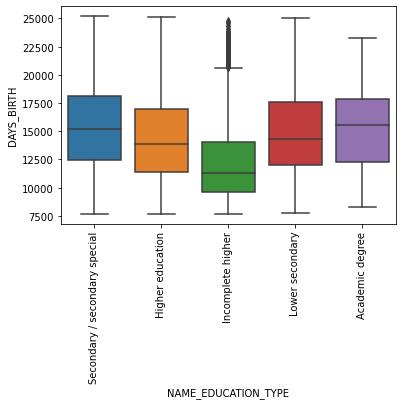

DAYS_BIRTH vs NAME_FAMILY_STATUS


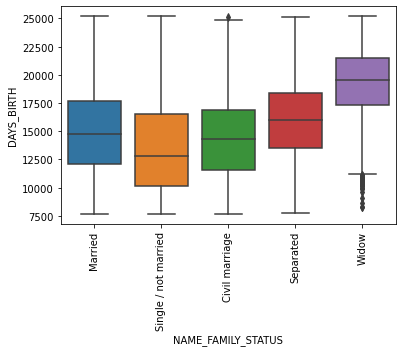

DAYS_BIRTH vs NAME_HOUSING_TYPE


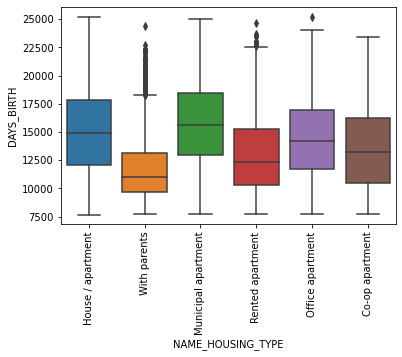

DAYS_BIRTH vs OCCUPATION_TYPE


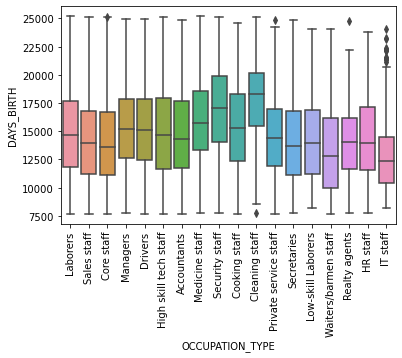

DAYS_BIRTH vs WEEKDAY_APPR_PROCESS_START


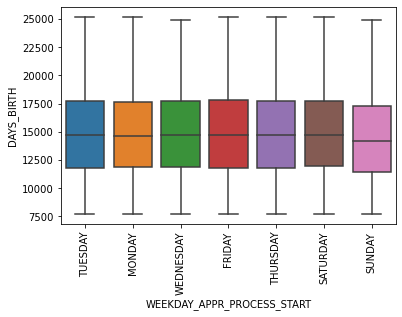

DAYS_BIRTH vs ORGANIZATION_TYPE


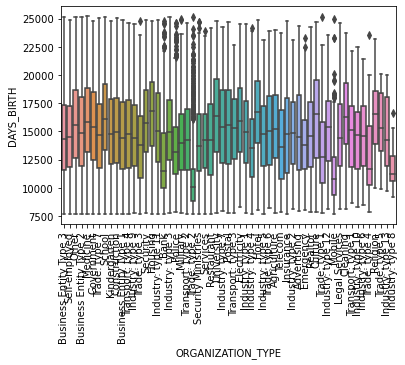

DAYS_EMPLOYED vs NAME_TYPE_SUITE


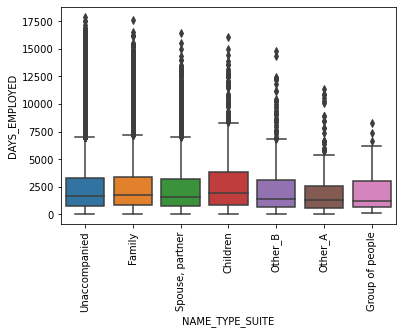

DAYS_EMPLOYED vs NAME_INCOME_TYPE


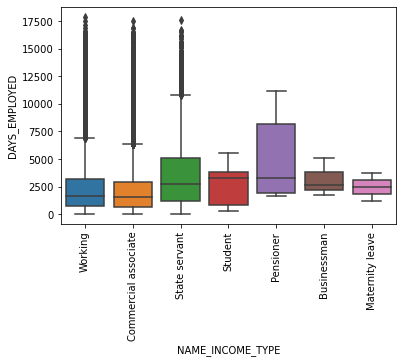

DAYS_EMPLOYED vs NAME_EDUCATION_TYPE


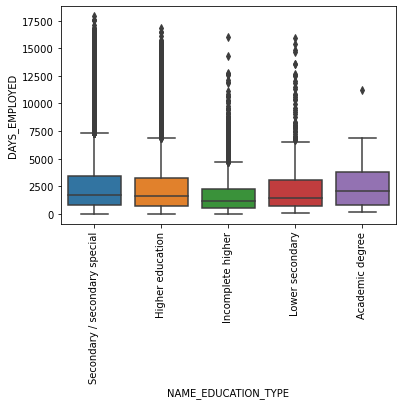

DAYS_EMPLOYED vs NAME_FAMILY_STATUS


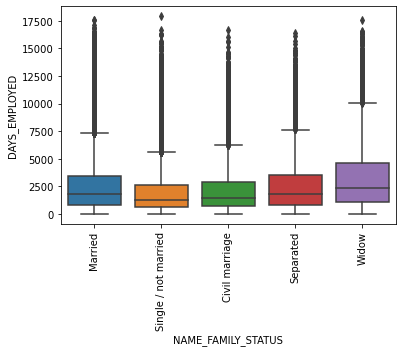

DAYS_EMPLOYED vs NAME_HOUSING_TYPE


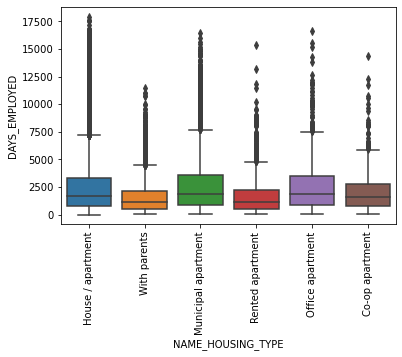

DAYS_EMPLOYED vs OCCUPATION_TYPE


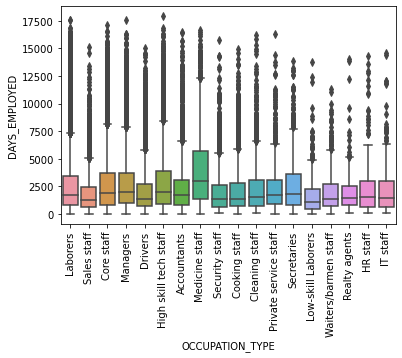

DAYS_EMPLOYED vs WEEKDAY_APPR_PROCESS_START


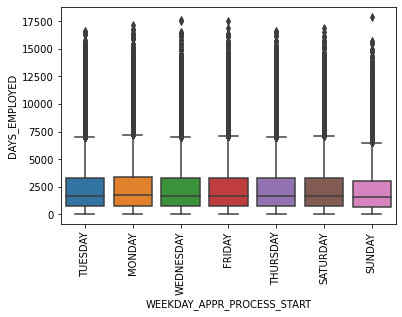

DAYS_EMPLOYED vs ORGANIZATION_TYPE


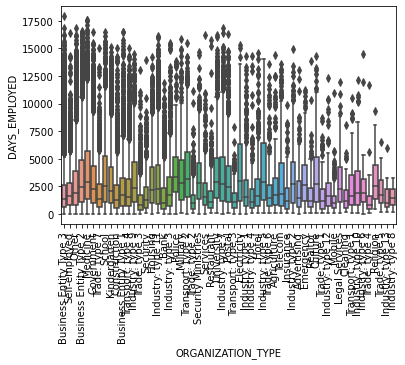

DAYS_ID_PUBLISH vs NAME_TYPE_SUITE


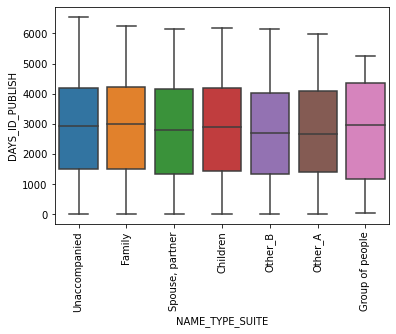

DAYS_ID_PUBLISH vs NAME_INCOME_TYPE


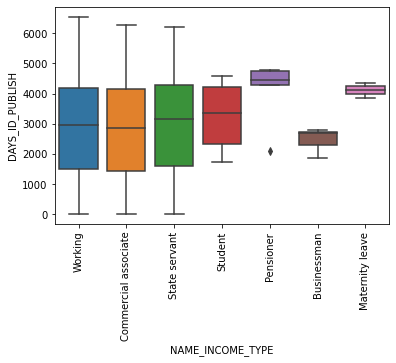

DAYS_ID_PUBLISH vs NAME_EDUCATION_TYPE


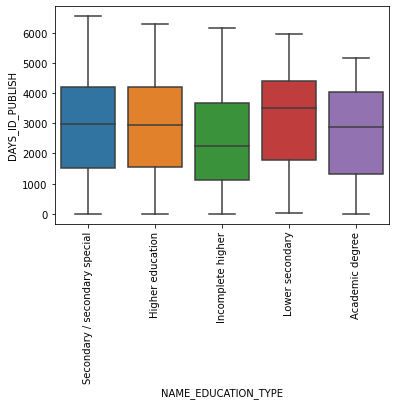

DAYS_ID_PUBLISH vs NAME_FAMILY_STATUS


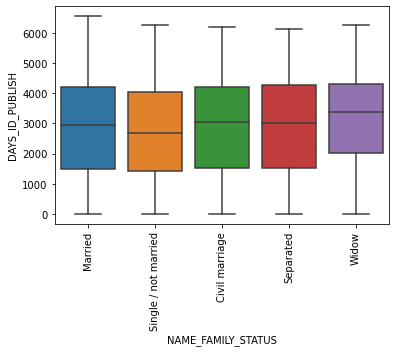

DAYS_ID_PUBLISH vs NAME_HOUSING_TYPE


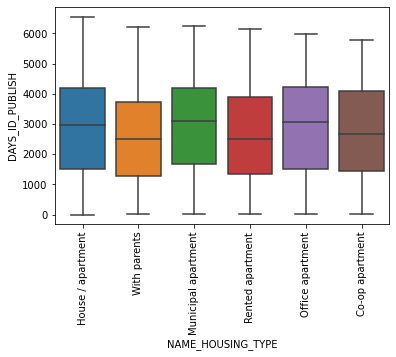

DAYS_ID_PUBLISH vs OCCUPATION_TYPE


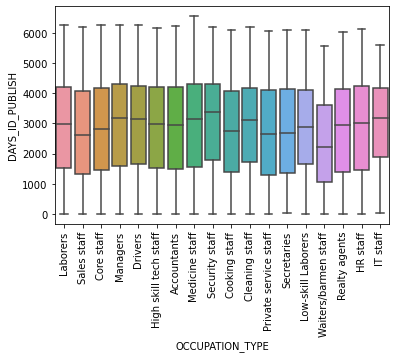

DAYS_ID_PUBLISH vs WEEKDAY_APPR_PROCESS_START


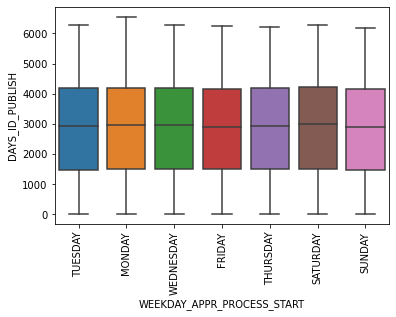

DAYS_ID_PUBLISH vs ORGANIZATION_TYPE


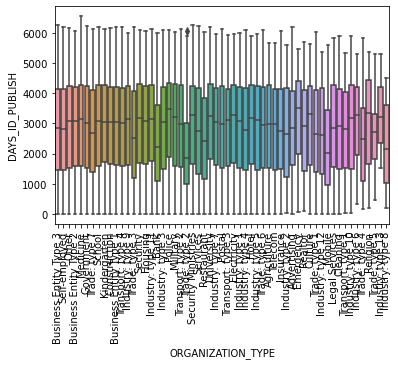

CNT_FAM_MEMBERS vs NAME_TYPE_SUITE


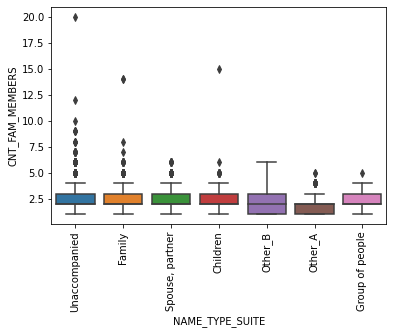

CNT_FAM_MEMBERS vs NAME_INCOME_TYPE


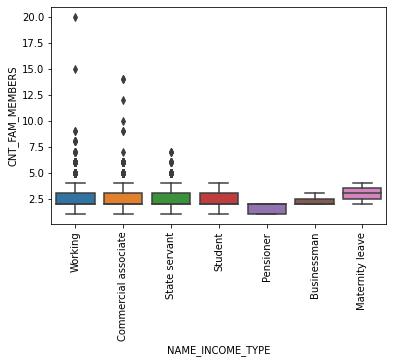

CNT_FAM_MEMBERS vs NAME_EDUCATION_TYPE


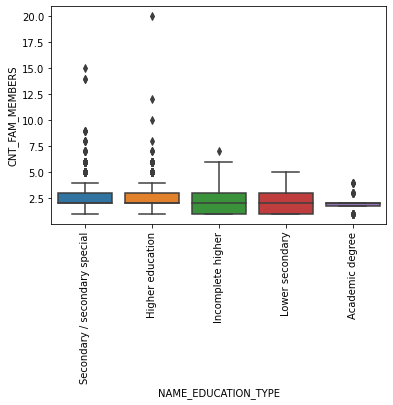

CNT_FAM_MEMBERS vs NAME_FAMILY_STATUS


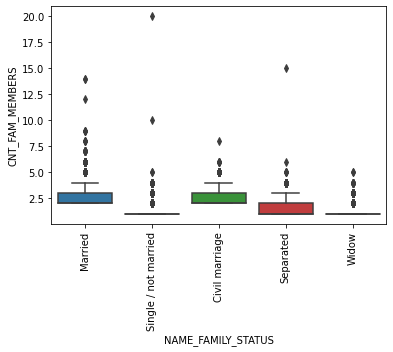

CNT_FAM_MEMBERS vs NAME_HOUSING_TYPE


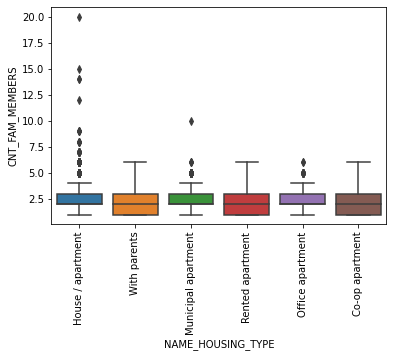

CNT_FAM_MEMBERS vs OCCUPATION_TYPE


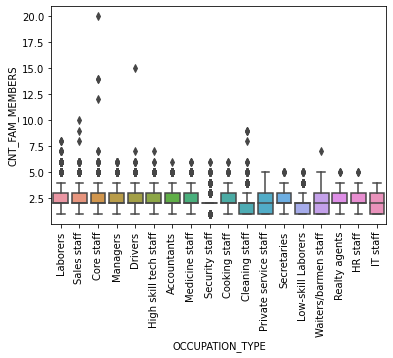

CNT_FAM_MEMBERS vs WEEKDAY_APPR_PROCESS_START


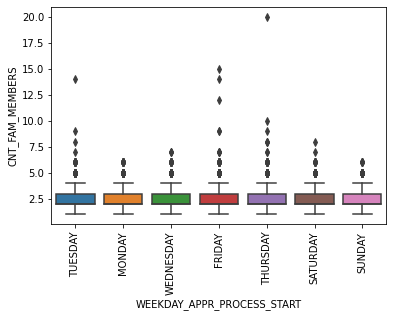

CNT_FAM_MEMBERS vs ORGANIZATION_TYPE


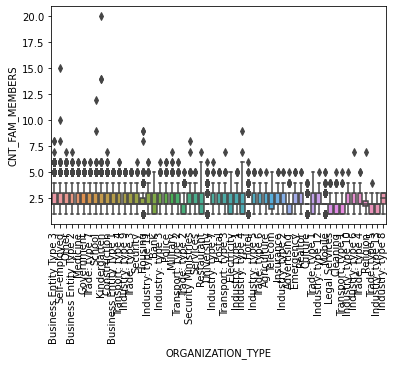

HOUR_APPR_PROCESS_START vs NAME_TYPE_SUITE


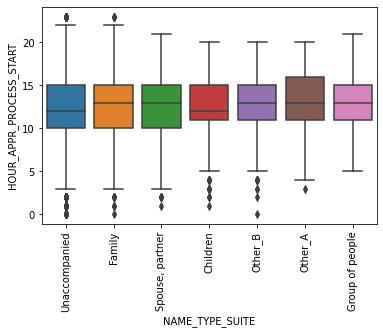

HOUR_APPR_PROCESS_START vs NAME_INCOME_TYPE


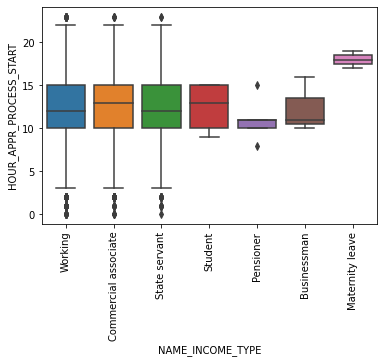

HOUR_APPR_PROCESS_START vs NAME_EDUCATION_TYPE


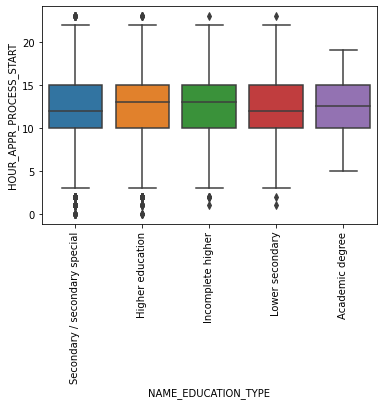

HOUR_APPR_PROCESS_START vs NAME_FAMILY_STATUS


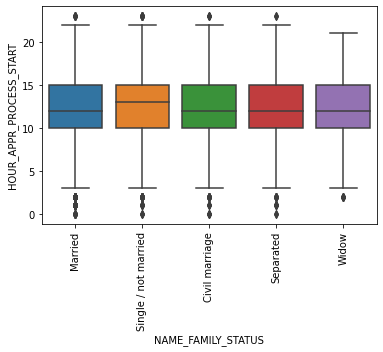

HOUR_APPR_PROCESS_START vs NAME_HOUSING_TYPE


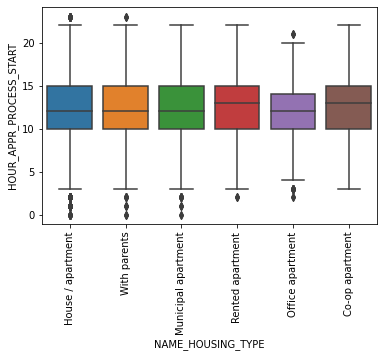

HOUR_APPR_PROCESS_START vs OCCUPATION_TYPE


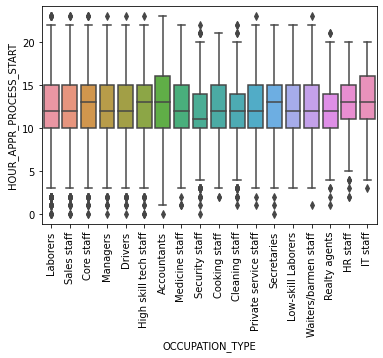

HOUR_APPR_PROCESS_START vs WEEKDAY_APPR_PROCESS_START


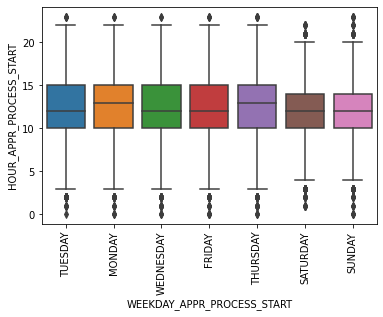

HOUR_APPR_PROCESS_START vs ORGANIZATION_TYPE


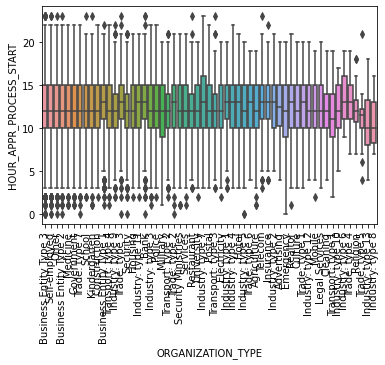

EXT_SOURCE_2 vs NAME_TYPE_SUITE


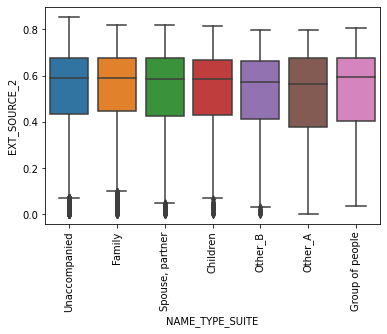

EXT_SOURCE_2 vs NAME_INCOME_TYPE


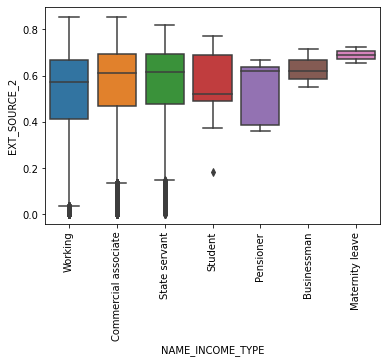

EXT_SOURCE_2 vs NAME_EDUCATION_TYPE


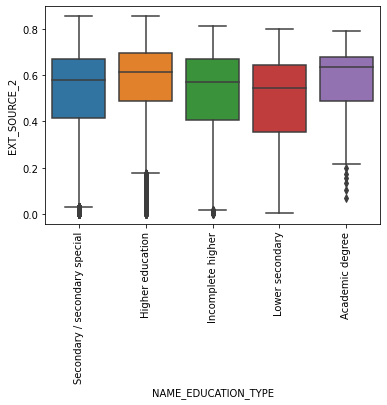

EXT_SOURCE_2 vs NAME_FAMILY_STATUS


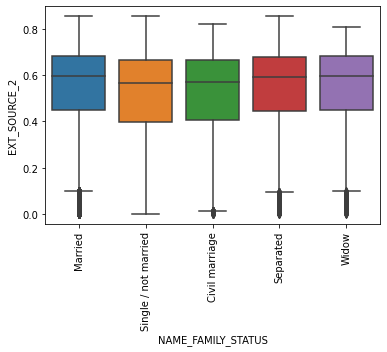

EXT_SOURCE_2 vs NAME_HOUSING_TYPE


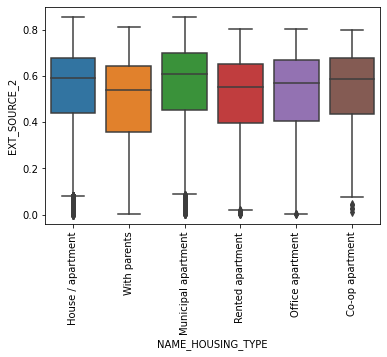

EXT_SOURCE_2 vs OCCUPATION_TYPE


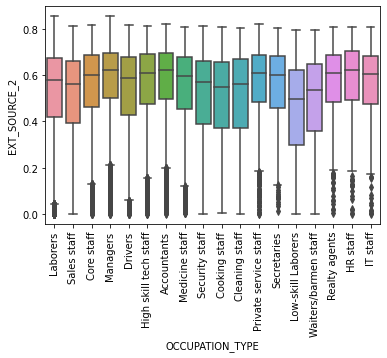

EXT_SOURCE_2 vs WEEKDAY_APPR_PROCESS_START


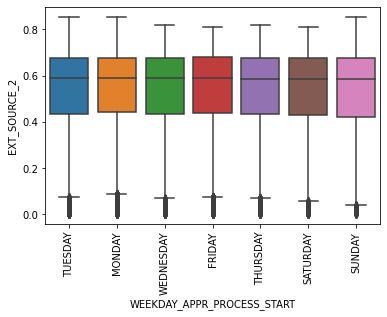

EXT_SOURCE_2 vs ORGANIZATION_TYPE


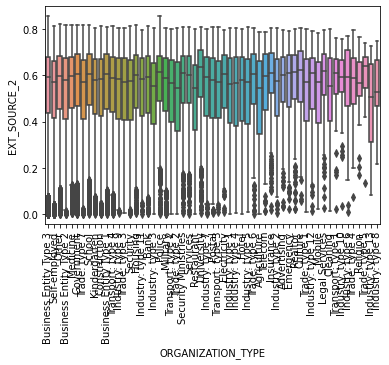

EXT_SOURCE_3 vs NAME_TYPE_SUITE


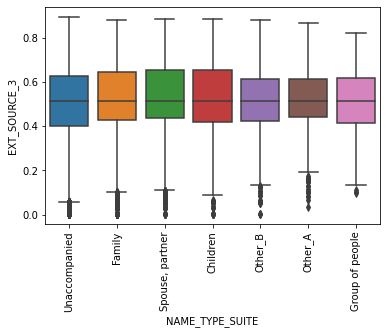

EXT_SOURCE_3 vs NAME_INCOME_TYPE


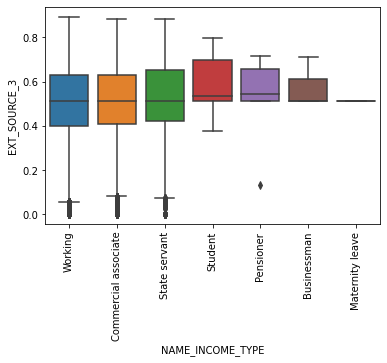

EXT_SOURCE_3 vs NAME_EDUCATION_TYPE


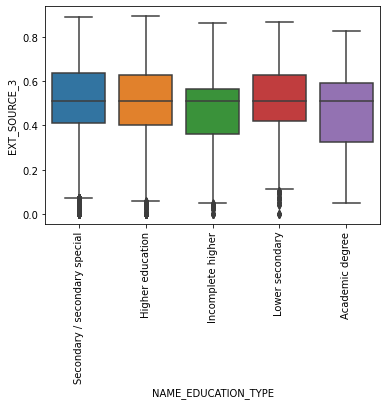

EXT_SOURCE_3 vs NAME_FAMILY_STATUS


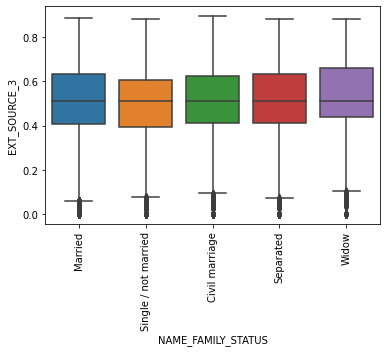

EXT_SOURCE_3 vs NAME_HOUSING_TYPE


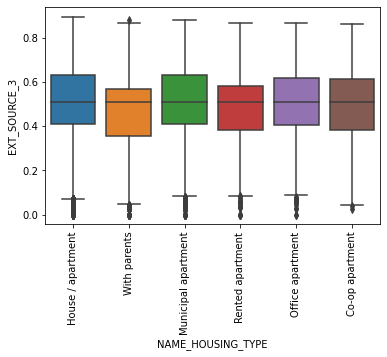

EXT_SOURCE_3 vs OCCUPATION_TYPE


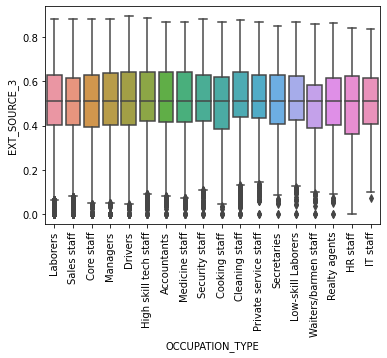

EXT_SOURCE_3 vs WEEKDAY_APPR_PROCESS_START


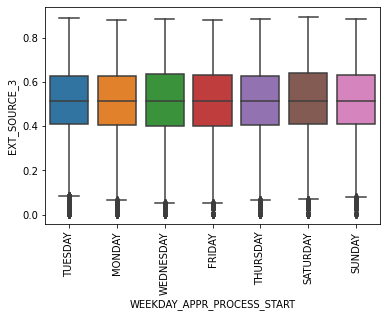

EXT_SOURCE_3 vs ORGANIZATION_TYPE


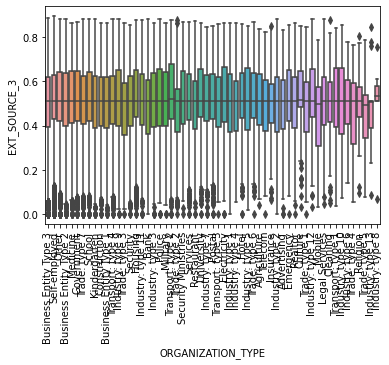

FLOORSMAX_MEDI vs NAME_TYPE_SUITE


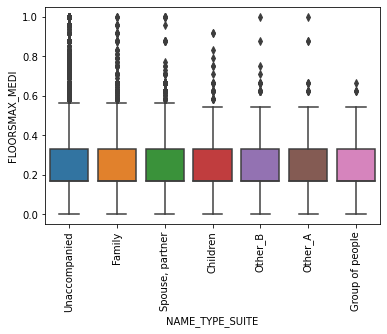

FLOORSMAX_MEDI vs NAME_INCOME_TYPE


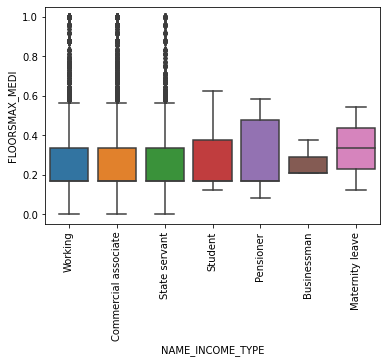

FLOORSMAX_MEDI vs NAME_EDUCATION_TYPE


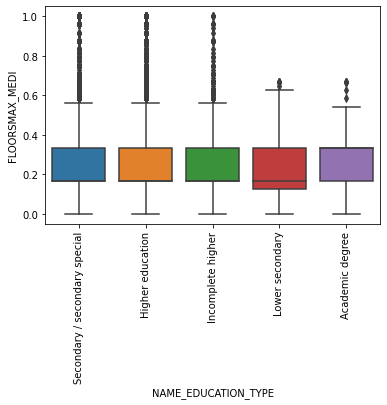

FLOORSMAX_MEDI vs NAME_FAMILY_STATUS


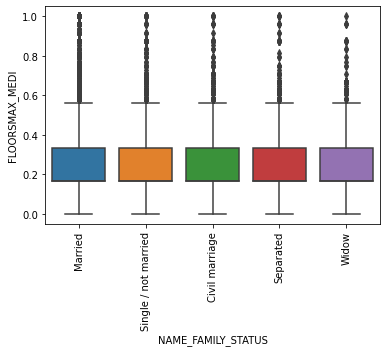

FLOORSMAX_MEDI vs NAME_HOUSING_TYPE


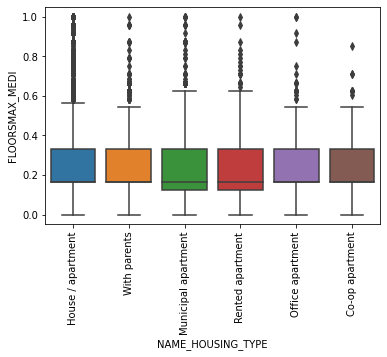

FLOORSMAX_MEDI vs OCCUPATION_TYPE


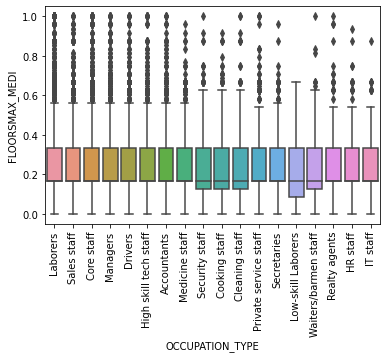

FLOORSMAX_MEDI vs WEEKDAY_APPR_PROCESS_START


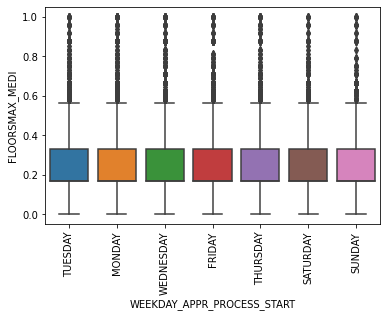

FLOORSMAX_MEDI vs ORGANIZATION_TYPE


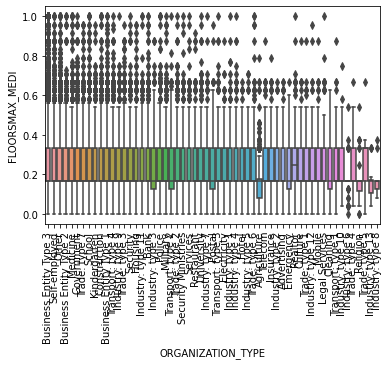

In [44]:
for j in range(len(cont_cols)):
    for i in range(len(cat_cols)):
        print(f'{cont_cols[j]} vs {cat_cols[i]}')
        cont_cat_boxplot(cat_cols[i], cont_cols[j])

Notice: For this analysis we will remove the redundant feature that is correlated to another existing one <br> 
because we need all features to be indepenedent <br> 
We can notice that AMT_INCOME_TOTAL vs NAME_INCOME_TYPE, AMT_INCOME_TOTAL vs NAME_EDUCATION_TYPE ,
 CNT_FAM_MEMBERS vs NAME_FAMILY_STATUS are dependent

In [45]:
# added NAME_EDUCATION_TYPE
clean_dataset.drop(['NAME_INCOME_TYPE',], axis = 1, inplace= True)
clean_dataset.shape

(121091, 24)

## 3.5 Multiple Categorical Vs Categorical
For this analysis we will use chi2 test to calculate the correlation between the variables

In [46]:
cat_cols = clean_dataset.columns[(clean_dataset.dtypes == 'object')]
cat_cols =np.append(cat_cols.values,binary_to_keep)
cat_cols

array(['NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'CODE_GENDER',
       'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_PHONE',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'FLAG_DOCUMENT_3', 'TARGET'], dtype=object)

In [47]:
to_encoded = clean_dataset.copy()
label = preprocessing.LabelEncoder()
encoded_data = pd.DataFrame(to_encoded)
for col in cat_cols:
    encoded_data[col] = label.fit_transform(to_encoded[col])


In [48]:
encoded_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_MEDI,FLAG_DOCUMENT_3
0,1,0,1,0,202500.0,6,4,3,1,9461,...,1.0,6,10,0,0,5,0.262949,0.139376,0.0833,1
1,0,0,0,0,270000.0,1,1,1,1,16765,...,2.0,1,11,0,0,39,0.622246,0.510853,0.2917,1
12,0,0,0,0,67500.0,6,4,1,1,13439,...,2.0,0,10,0,0,4,0.715042,0.176653,0.1667,1
13,0,0,1,1,225000.0,6,4,1,1,14086,...,3.0,4,13,0,0,42,0.566907,0.770087,0.3333,1
14,0,0,0,0,189000.0,6,4,1,1,14583,...,2.0,1,9,0,0,53,0.642656,0.510853,0.6667,1


In [49]:
def calc_cramerV(col1, col2):
    cross_table = pd.crosstab(col1, col2)
    chi2 = chi2_contingency(cross_table)[0]
    n = cross_table.sum().sum()
    phi2 = chi2/n
    r,k = cross_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

rows = []
for i in range(len(cat_cols)):
    cols = []
    for j in range(len(cat_cols)):
        V = calc_cramerV(encoded_data[cat_cols[i]],encoded_data[cat_cols[j]])
        cols.append(V)
    rows.append(cols)

In [50]:
corr_matrix = pd.DataFrame(data = rows, index= cat_cols,columns = cat_cols )
corr_matrix

,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
NAME_TYPE_SUITE,1.000000,0.018906,0.068656,0.016717,0.016042,0.019682,0.017333,0.051317,0.011740,0.029649,0.016641,0.012409,0.006139,0.026942,0.009162
NAME_EDUCATION_TYPE,0.018906,1.000000,0.048995,0.046394,0.188883,0.005622,0.115908,0.056744,0.051990,0.084034,0.032199,0.033869,0.018563,0.097714,0.059673
NAME_FAMILY_STATUS,0.068656,0.048995,1.000000,0.071381,0.062511,0.005959,0.051494,0.141862,0.040598,0.146284,0.030438,0.040669,0.029026,0.046004,0.040692
NAME_HOUSING_TYPE,0.016717,0.046394,0.071381,1.000000,0.031076,0.002600,0.054711,0.058441,0.022851,0.042957,0.029584,0.136045,0.078540,0.034669,0.028932
OCCUPATION_TYPE,0.016042,0.188883,0.062511,0.031076,1.000000,0.018664,0.282893,0.485899,0.042862,0.232836,0.037867,0.025922,0.067530,0.120131,0.065854
WEEKDAY_APPR_PROCESS_START,0.019682,0.005622,0.005959,0.002600,0.018664,1.000000,0.019423,0.002166,0.017242,0.008938,0.020541,0.002205,0.007404,0.015028,0.008655
ORGANIZATION_TYPE,0.017333,0.115908,0.051494,0.054711,0.282893,0.019423,1.000000,0.306180,0.031034,0.138782,0.042254,0.057817,0.120244,0.131586,0.057475
CODE_GENDER,0.051317,0.056744,0.141862,0.058441,0.485899,0.002166,0.306180,0.999982,0.016133,0.315108,0.012706,0.023230,0.088937,0.154636,0.050180
NAME_CONTRACT_TYPE,0.011740,0.051990,0.040598,0.022851,0.042862,0.017242,0.031034,0.016133,0.999956,0.000000,0.019584,0.008023,0.000000,0.566283,0.034848
FLAG_OWN_CAR,0.029649,0.084034,0.146284,0.042957,0.232836,0.008938,0.138782,0.315108,0.000000,0.999982,0.004667,0.000000,0.035905,0.145726,0.026367


From the above matrix the correlation between we will remove a feature if correlated with another for over 85% <br> 
and we will keep a features if correlated with target output for over 5%

In [167]:
# correlated with target 
f_sel_data = clean_dataset.copy()
f_sel_data.drop(['NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
                    'FLAG_OWN_CAR', 'FLAG_PHONE', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY'], axis = 1, inplace= True)
# total_features = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'CODE_GENDER','DAYS_EMPLOYED','AMT_INCOME_TOTAL',
#                  'CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']
# # ,

In [168]:
f_sel_data.head()
# f_sel_data = f_sel_data[total_features]
# f_sel_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_MEDI,FLAG_DOCUMENT_3
0,1,0,1,202500.0,Secondary / secondary special,Single / not married,9461,637,2120,Laborers,1.0,10,Business Entity Type 3,0.262949,0.139376,0.0833,1
1,0,0,0,270000.0,Higher education,Married,16765,1188,291,Core staff,2.0,11,School,0.622246,0.510853,0.2917,1
12,0,0,0,67500.0,Secondary / secondary special,Married,13439,2717,3227,Laborers,2.0,10,Business Entity Type 2,0.715042,0.176653,0.1667,1
13,0,0,1,225000.0,Secondary / secondary special,Married,14086,3028,4911,Drivers,3.0,13,Self-employed,0.566907,0.770087,0.3333,1
14,0,0,0,189000.0,Secondary / secondary special,Married,14583,203,2056,Laborers,2.0,9,Transport: type 2,0.642656,0.510853,0.6667,1


# Univariate Analaysis (Understand the Variables) 

### Distribution of applications

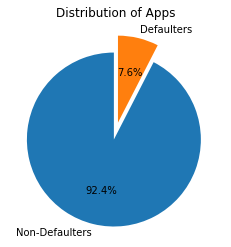

In [169]:
labels = [ 'Non-Defaulters', 'Defaulters']
plt.title("Distribution of Apps")
_ = plt.pie(f_sel_data.TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)

Notice: that our dataset has 93% Non-Defaulters and 7% Defaulters so our dataset is <b>Impalanced<b>

### Female Vs Male applicants 

[Text(0, 0, 'Non-Defaulter'), Text(1, 0, 'Defaulter')]

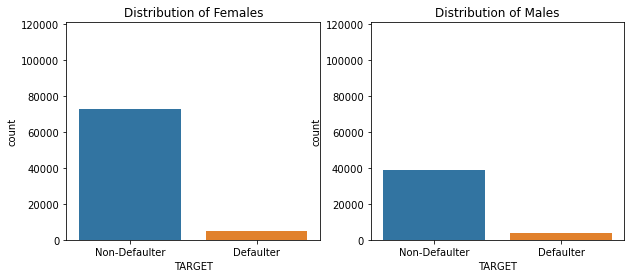

In [170]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(4)
_ = sns.countplot(x = 'TARGET', data= f_sel_data[f_sel_data.CODE_GENDER == 0], ax= ax1)
ax1.set_title('Distribution of Females')
ax1.set_ylim(0, len(f_sel_data))
ax1.set_xticklabels(['Non-Defaulter', 'Defaulter'])

_ = sns.countplot(x = 'TARGET', data= f_sel_data[f_sel_data.CODE_GENDER == 1], ax= ax2)
ax2.set_title('Distribution of Males')
ax2.set_ylim(0, len(f_sel_data))
ax2.set_xticklabels(['Non-Defaulter', 'Defaulter'])

Notice: Here the number of Non-defalters for men is less than the number of defaulters for women
To get better insight we better calculate percentage

Text(0.5, 1.0, 'Percentage of Females')

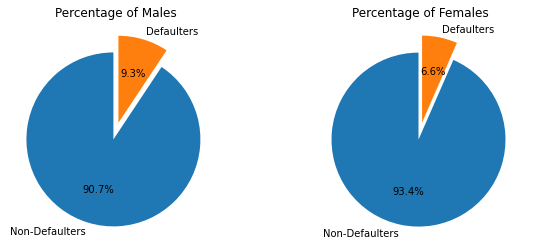

In [171]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(4)
labels = [ 'Non-Defaulters', 'Defaulters']
ax1.pie(f_sel_data[f_sel_data.CODE_GENDER == 1].TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)
ax1.set_title('Percentage of Males')

ax2.pie(f_sel_data[f_sel_data.CODE_GENDER == 0].TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)
ax2.set_title('Percentage of Females')


Notice: Now we can see that the percentage of Non-Defaulted females is larger than men 

###  Family members for females and males 

<AxesSubplot:title={'center':'Occupation type for Females'}, xlabel='OCCUPATION_TYPE', ylabel='count'>

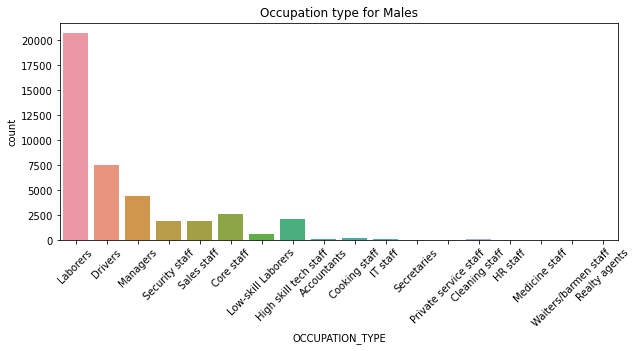

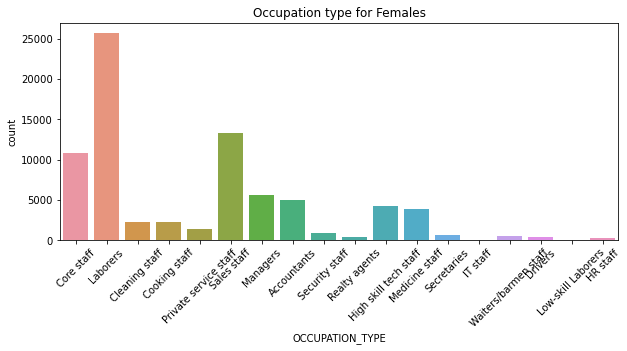

In [172]:
plt.figure(figsize=(10,4))
plt.xticks(rotation = 45)
plt.title("Occupation type for Males")
sns.countplot(x = 'OCCUPATION_TYPE', data= f_sel_data[f_sel_data.CODE_GENDER == 1])
plt.figure(figsize=(10,4))
plt.xticks(rotation = 45)
plt.title("Occupation type for Females")
sns.countplot(x = 'OCCUPATION_TYPE', data= f_sel_data[f_sel_data.CODE_GENDER == 0])



Notice: we can see that most people who want a credit are laborers<br> 

In [173]:
X = f_sel_data.copy()

# Learning Model

### Encoding Categorial Features

In [174]:
X.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_MEDI,FLAG_DOCUMENT_3
0,1,0,1,202500.0,Secondary / secondary special,Single / not married,9461,637,2120,Laborers,1.0,10,Business Entity Type 3,0.262949,0.139376,0.0833,1
1,0,0,0,270000.0,Higher education,Married,16765,1188,291,Core staff,2.0,11,School,0.622246,0.510853,0.2917,1
12,0,0,0,67500.0,Secondary / secondary special,Married,13439,2717,3227,Laborers,2.0,10,Business Entity Type 2,0.715042,0.176653,0.1667,1
13,0,0,1,225000.0,Secondary / secondary special,Married,14086,3028,4911,Drivers,3.0,13,Self-employed,0.566907,0.770087,0.3333,1
14,0,0,0,189000.0,Secondary / secondary special,Married,14583,203,2056,Laborers,2.0,9,Transport: type 2,0.642656,0.510853,0.6667,1


In [175]:
Y = X.TARGET
X.drop(['TARGET'] , axis = 1, inplace = True)

In [189]:
num_cols = ['DAYS_BIRTH','FLOORSMAX_MEDI','HOUR_APPR_PROCESS_START','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_EMPLOYED','AMT_INCOME_TOTAL']
min_v = X[num_cols].min(axis = 0)
X[num_cols] = X[num_cols] - min_v
X[num_cols] /= X[num_cols].max(axis = 0)

In [190]:
encoder = OneHotEncoder(drop='if_binary', sparse=True)
cat_cols = X.columns[X.dtypes == 'object']
encoded_cols = encoder.fit_transform(X[cat_cols])
# cat_cols

In [191]:

encoded_X = X.drop(cat_cols, axis = 1)
encoded_X = np.append( encoded_cols.toarray(), encoded_X.to_numpy(), axis= 1)

In [192]:
# # save clean encoded features
# df = pd.DataFrame(encoded_X)
# df.to_csv('final_dataset.csv')
encoded_X.shape

(121091, 97)

In [193]:
encoded_X.max()

1.0

### Training SVM Model 

In [194]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import  sklearn.svm as svm
import pickle

In [195]:
# load final dataset 
# final_dataset = pd.read_csv('final_dataset.csv')
# X = final_dataset.to_numpy()
# final_dataset.head()

In [196]:
def svm_clf(X_train, X_test, y_train, y_test, nu = 0.5,c = 1.0):
    #fit model
    clf = svm.NuSVC(gamma='auto',nu=nu)
    clf.fit(X_train, y_train)
    
    #predict train set
    train_pred = clf.predict(X_train)
    print(f'Training Accuracy: {(train_pred == y_train).mean()*100:.2f}')
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Training Confuction Matrix")
    ax2.set_title("Testing Confuction Matrix")
    plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9, top=0.9, wspace=0.5, hspace=0.4)
    
    cm = confusion_matrix(y_train, train_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax = ax1)
     
    # predict test set 
    test_pred = clf.predict(X_test)
    print(f'Test Accuracy: {(test_pred == y_test).mean()*100:.2f}')
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax = ax2)

# SVM Clf on Impalanced Data

In [137]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, Y, test_size=0.2 )

In [ ]:
svm_clf(X_train, X_test, y_train, y_test,.1)

In [316]:
pickle.dump(clf, open('svm_classifier.sav','wb'))

Notice: the model predicts all examples as '0' because we showed before that the dataset is impalanced 
we need to apply undersampling or oversampling to palance the dataset

### Under Sampling data using RandomUnderSampler 

In [197]:
# !pip install imblearn
rus = RandomUnderSampler(random_state=0)
X_res, y_res = rus.fit_resample(encoded_X,Y)

<BarContainer object of 2 artists>

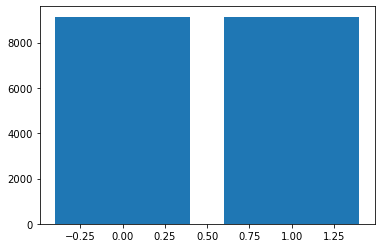

In [198]:
plt.bar([0,1], [len(y_res) - y_res.sum(),y_res.sum()])

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2 )

In [200]:
print(f"Original Train data shape{encoded_X.shape}")
print(f"Resampled Train data shape{X_res.shape}")
y_train.mean()

Original Train data shape(121091, 97)
Resampled Train data shape(18288, 97)


0.5017771701982229

Training Accuracy: 67.05
Test Accuracy: 58.97


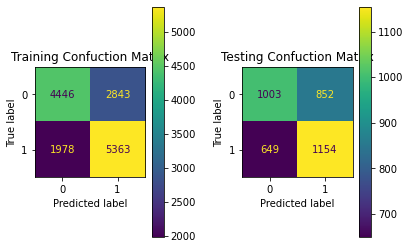

In [201]:
svm_clf(X_train, X_test, y_train, y_test, c = 1)

### OverSampling

<BarContainer object of 2 artists>

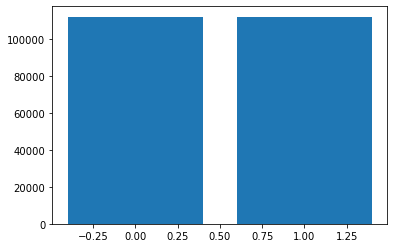

In [172]:
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(encoded_X, Y)
plt.bar([0,1], [len(y_res) - y_res.sum(),y_res.sum()])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_res[:,:-1], y_res, test_size=0.2 )
print(f"Original Train data shape{X.shape}")
print(f"Resampled Train data shape{X_res.shape}")
y_train.mean()

Original Train data shape(121091, 16)
Resampled Train data shape(223894, 97)


0.5003712698545627

In [ ]:
svm_clf(X_train, X_test, y_train, y_test)

# KNN Classifier 

In [208]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors= 151)
knn_clf.fit(X_train, y_train)
train_pred = knn_clf.predict(X_train)
test_pred = knn_clf.predict(X_test)
print(f'{int(np.sqrt(len(X_train)))}-NN Clf -> Train Accuracy: {(train_pred == y_train).mean()*100:.2f},  Test Accuracy: {(test_pred == y_test).mean()*100:.2f}')


120-NN Clf -> Train Accuracy: 64.40,  Test Accuracy: 62.85
